In [142]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Imports

In [143]:
# from sklearnex import patch_sklearn
# patch_sklearn()

from psutil._common import bytes2human
import time
import sys
import numpy as np
import torch as tc
# import skdim
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from hummingbird.ml import convert
from scipy.integrate import solve_ivp, odeint
import scipy.signal as signal
import pypsr as pyps
import re
from datetime import datetime
from tqdm.notebook import tqdm, trange
import gzip
import os
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from matplotlib import rc
%matplotlib inline

np.set_printoptions(linewidth=250)

font_dir = 'C:/Users/AdamG/Anaconda3/Lib/site-packages/matplotlib/mpl-data/fonts/ttf/'
# font_dir = '/Users/adamgiammarese/Library/Fonts/'

# Set Directories

In [144]:
base_dir = base_dir = os.getcwd().replace('\\','/') + '/'

fig_dir = base_dir + 'Figures/Lorenz Comparison/'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)

data_dir = base_dir + 'Lorenz_Data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

os.chdir(base_dir)

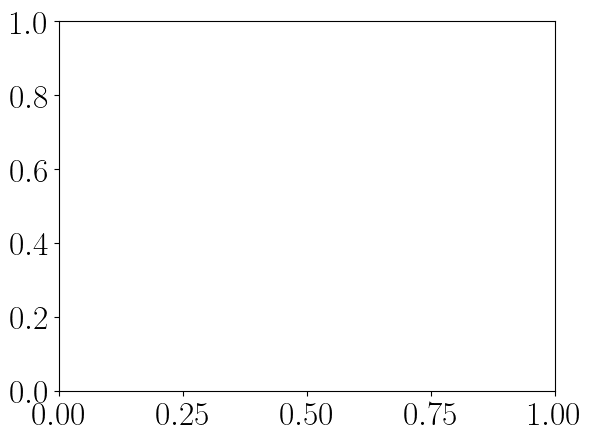

In [145]:
# !cp Helvetica.ttf $font_dir

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
plt.xticks(fontname = 'Helvetica')
plt.yticks(fontname = 'Helvetica')
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{xfrac}')


plt.rcParams['savefig.bbox'] = 'tight'

import matplotlib.font_manager as fm
fm.fontManager.addfont(font_dir + 'Helvetica.ttf')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

prop = fm.FontProperties(fname=font_dir+'Helvetica.ttf')
font = {'fontname':'Helvetica'}

# Helper Functions

In [146]:
tc.backends.cuda.is_built()

True

In [147]:
tc.backends.cudnn.is_available()

True

In [203]:
def lorenz(X,t,sigma=10,beta=8/3,rho=28):
    x, y, z = X
    dx = sigma*(y-x)
    dy = x*(rho-z) - y
    dz = x*y - beta*z
    return [dx, dy, dz]

def evolve(f,Tmax,dt,x0,sigma=10,beta=8/3,rho=28):
    t = np.arange(0,Tmax,dt)
    result = odeint(f, x0, t, args=(sigma,beta,rho))
    x,y,z = result.T
    return x,y,z,t

def lead_data(data,stride=1,lead=1):
    n_samples = len(data) - lead
    n_dims = data.shape[1]
    features = np.zeros((n_samples//stride,n_dims))
    labels = np.zeros((n_samples//stride,n_dims))
    for i in range(n_samples//stride):
        j = i*stride
        features[i,:] = data[j,:].flatten()
        labels[i,:] = data[j+lead,:].flatten()
    return features, labels

def get_tau_crits(X_train, p_val=0.05, max_lag=600, make_plot=False, 
                  dim_labels=['x','y','z'], save_fig=False, fname=''):
    amis = []
    N = X_train.shape[1]
    
    if dim_labels is None:
        dim_labels = np.arange(N).astype(str)
    
    max_lag = len(X_train)//2 if max_lag is None else max_lag

    for i in range(N):
        lags, ami = pyps.lagged_ami(X_train[:,i], max_lag=max_lag)
        amis.append(ami)
    amis = np.array(amis).T
    
    for i in range(N):
        amis[:,i] /= amis[0,i]
        
    tau_crits = []
    for i in range(N):
        for j in range(max_lag):
            if amis[j,i] <= p_val:
                break
        tau_crits += [j-1]
        
    if make_plot:
        fontsize = 32
        ms = 10
        lw = 2
        
        yticks = [0, 0.5, 1]


        ylim = [0,1]
        xy_annotate = (0.01,0.95)

        plt.rc('text', usetex=True)
        plt.rc('xtick',labelsize=fontsize)
        plt.rc('ytick',labelsize=fontsize)
        
        fig, axs = plt.subplots(N,1,figsize=(12,3*N),sharex=True)
        axs_lst = [axs] if N==1 else axs
        
        for i, ax in enumerate(axs_lst):
            ax.plot(lags,amis[:,i],'k',lw=lw)
            
            ax.axhline(p_val, ls='--', lw=lw, c='r')
            ax.axvline(tau_crits[i], ls='--', lw=lw, c='r')
            
            ax.set_xlim(0, max_lag)
            ax.set_ylim(ylim)
            ax.text(0.99*max_lag, p_val+0.01, f'$pval={p_val}$', fontsize=fontsize, va='bottom', ha='right',
                    color='r')
            if tau_crits[i] >= max_lag/2:
                ax.text(tau_crits[i]-0.01*max_lag,0.9,
                     r'$\tau_{'+f'{i+1}'+r',crit}'+r'={:d}$'.format(tau_crits[i]),fontsize=fontsize,
                     va='top', ha='right', color='r')
            else:
                ax.text(tau_crits[i]+0.01*max_lag,0.9,
                     r'$\tau_{'+f'{i+1}'+r',crit}'+r'={:d}$'.format(tau_crits[i]),fontsize=fontsize,
                     va='top', ha='left', color='r')
            
            xticks = ax.get_xticks()
            ax.set_xticks(xticks)
            ax.set_xticklabels([f'{xtick:.0f}' for xtick in xticks], fontsize=fontsize)
            
            # peaks = signal.argrelextrema(amis[:,i], np.greater)[0]
            # ax.plot(peaks,amis[peaks,i],'ro',ms=ms,label='Peaks')
            ax.set_ylabel(r'$AMI_{:}(\tau)$'.format(dim_labels[i]), fontsize=fontsize)
            # ax1.legend(loc='upper right',prop={'size': 24})
            ax.annotate(r'\textbf{('+chr(97+i)+')}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
#             ax.set_xticks(xticks)
            # ax1.set_xticklabels(xticks, fontsize=fontsize)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks, fontsize=fontsize)
    
            if i == N - 1:
                ax.set_xlabel(r'$\tau$', fontsize=fontsize)
                
            plt.setp(ax.spines.values(), linewidth=2, zorder=100)
            ax.tick_params(length=10,width=2)
            
            ax.set_zorder(N-i)
    
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.2,wspace=0.15)
        fig.align_labels(axs)
        
        if save_fig:
            plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
            plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

        plt.show()
    
    return tau_crits    

def make_features_and_labels(data,k,xi=1,stride=1,lead=1):
    n_samples = len(data) - (k-1)*xi - lead
    n_dims = data.shape[1]
    features = np.zeros((n_samples//stride,k*n_dims))
    labels = np.zeros((n_samples//stride,n_dims))
    for i in range(n_samples//stride):
        j = i*stride
        features[i,:] = data[j:j+k*xi:xi,:].T.flatten()
        labels[i,:] = data[j+(k-1)*xi+lead,:].flatten()
    return features, labels

def feature_selection(features, labels, n_estimators=100, max_depth=None,
                      random_state=None, n_jobs=-1, n_samples=None,
                      model_type='RFR', verbose=False):
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    start_time = time.time()
    stride = 1 if n_samples is None else len(features)//n_samples
    if model_type == 'RFR':
        Regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs, verbose=verbose).fit(features[::stride],
                                                                                                   labels[::stride])
    else:
        Regressor = ExtraTreesRegressor(n_estimators=n_estimators, random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs, verbose=verbose).fit(features[::stride],
                                                                                                 labels[::stride])
    end_time = time.time()
    if verbose:
        print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
        print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(Regressor))))
    return Regressor.feature_importances_, end_time-start_time

def future_prediction(features, labels, FIs, future, p=None, xi=1,
                      n_estimators=200, disp_progress=False, desc='',
                      max_depth=None, random_state=None, n_jobs=-1,
                      min_samples_split=2, min_samples_leaf=1, ccp_alpha=0,
                      max_features=1.0, n_samples=None, model=None, s=None,
                      model_type='RFR', verbose=False, model_conversion=None,
                      device='cuda'):
    N = np.shape(labels)[1]
    k = np.shape(FIs)[0]//N
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    if p is None:
        p = len(np.where(FIs >= np.mean(FIs))[0])
        if verbose or disp_progress:
            print(f'Num features selected: {p} of {len(FIs)}')
    elif type(p) != int:
        p = round(p*len(FIs))
    else:
        if p < 0:
            p = len(FIs)
    ind = np.argsort(-FIs)[:p]
    start_time = time.time()
    if model is None:
        stride = 1 if n_samples is None else len(features)//n_samples if type(n_samples) == int else round(len(features)*n_samples)
        if model_type == 'RFR':
            model = RandomForestRegressor(n_estimators=n_estimators,
                                          random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          ccp_alpha=ccp_alpha, verbose=verbose)
            #         elif model_type == 'GBR':
            #             model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=random_state, max_depth=max_depth, verbose=True)
            #         elif model_type == 'HGBR':
            #             model = HistGradientBoostingRegressor(max_iter=n_estimators, random_state=random_state, verbose=True)
        else:
            model = ExtraTreesRegressor(n_estimators=n_estimators,
                                        random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        max_features=max_features,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        ccp_alpha=ccp_alpha, verbose=verbose)
        model = model.fit(features[::stride,ind],labels[::stride])
        
        end_time = time.time()
        if verbose or disp_progress:
            print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
            print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(model))))
            
        if model_conversion == 'hummingbird':
            start_convert = time.time()
            model = convert(model, 'torch', extra_config={"tree_implementation":"tree_trav"})
            model.to(device)
            end_convert = time.time()
            if verbose or disp_progress:
                print(f'Conversion time ({model_conversion}):', datetime.utcfromtimestamp(end_convert-start_convert).strftime('%H hours, %M minutes, %S.%f seconds'))
            
            
    prediction = np.zeros((future,N))
    if s is None:
        s = features[-1].reshape((N,k*xi)) # shape (N, k*xi)
    else:
        s = s.reshape((N,k*xi)) # shape k*xi
    s_delayed = s[:,-(k-1)*xi-1::xi] # length k

    if disp_progress:
        lst = trange(future,desc=desc)
    else:
        lst = range(future)
    for i in lst:
        y_pred = model.predict(s_delayed.flatten()[ind].reshape(1, -1))[0].reshape((N,1))
        prediction[i,:] = y_pred.reshape(-1,)
        s = np.hstack((s.reshape((N,k*xi))[:,1:],y_pred))
        s_delayed = s[:,-(k-1)*xi-1::xi]
    prediction = np.array(prediction)
    end_time = time.time()
    if verbose or disp_progress:
        print('Total time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
    return prediction, model, end_time-start_time

def future_prediction_lead(features, labels, FIs, future, lead=1, p=None, xi=1, n_estimators=200,
                           disp_progress=False, desc='', leave=False, max_depth=None, random_state=None,
                           n_jobs=-1, min_samples_split=2, min_samples_leaf=1, ccp_alpha=0, max_features=1.0,
                           n_samples=None, model=None, y_train=None, y_test=None, model_type='RFR', verbose=False,
                           open_loop=True, model_conversion=None, device='cuda'):
    N = np.shape(labels)[1]
    k = np.shape(FIs)[0]//N
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    if p is None:
        p = len(np.where(FIs >= np.mean(FIs))[0])
        if verbose or disp_progress:
            print(f'Num features selected: {p} of {len(FIs)}')
    elif type(p) != int:
        p = round(p*len(FIs))
    else:
        if p < 0:
            p = len(FIs)
    ind = np.argsort(-FIs)[:p]
    start_time = time.time()
    if model is None:
        stride = 1 if n_samples is None else len(features)//n_samples if type(n_samples) == int else round(len(features)*n_samples)
        if model_type == 'RFR':
            model = RandomForestRegressor(n_estimators=n_estimators,
                                          random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          ccp_alpha=ccp_alpha, verbose=verbose)
        else:
            model = ExtraTreesRegressor(n_estimators=n_estimators,
                                        random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        max_features=max_features,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        ccp_alpha=ccp_alpha, verbose=verbose)
        model = model.fit(features[::stride,ind],labels[::stride])
        end_time = time.time()
        
        end_time = time.time()
        if verbose or disp_progress:
            print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
            print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(model))))
            
        if model_conversion == 'hummingbird':
            start_convert = time.time()
            model = convert(model, 'torch', extra_config={"tree_implementation":"tree_trav"})
            model.to(device)
            end_convert = time.time()
            if verbose or disp_progress:
                print(f'Conversion time ({model_conversion}):', datetime.utcfromtimestamp(end_convert-start_convert).strftime('%H hours, %M minutes, %S.%f seconds'))
    
    
    if open_loop:
        s = y_train[-(k-1)*xi-lead:len(y_train)-(lead-1)].T.flatten().reshape((N,(k-1)*xi+1))
        s_delayed_open_loop = np.zeros((future,p))
        for i in range(future):
            s_delayed_open_loop[i,:] = s[:,::xi].flatten()[ind]
            if i >= lead - 1:
                s = np.hstack((s.flatten()[1:],y_test[i+1-lead])).reshape((N,(k-1)*xi+1))
            else:
                s = np.hstack((s.flatten()[1:],y_train[len(y_train)-(lead-1)+i])).reshape((N,(k-1)*xi+1))
            
        prediction = model.predict(s_delayed_open_loop).reshape(-1,1)
    else:
        prediction = np.zeros((future,N))

        s = y_train[-(k-1)*xi-lead:len(y_train)-(lead-1)].T.flatten().reshape((N,(k-1)*xi+1))
        s_delayed = s[:,::xi]
        
        if disp_progress:
            lst = trange(future,desc=desc,leave=leave)
        else:
            lst = range(future)
        for i in lst:
            y_pred = model.predict(s_delayed.flatten()[ind].reshape(1, -1))[0].reshape((N,1))
            prediction[i,:] = y_pred
            if i >= lead - 1:
                s = np.hstack((s.flatten()[1:],y_test[i+1-lead])).reshape((N,(k-1)*xi+1))
            else:
                s = np.hstack((s.flatten()[1:],y_train[len(y_train)-(lead-1)+i])).reshape((N,(k-1)*xi+1))
            s_delayed = s[:,::xi]
            
    prediction = np.array(prediction)
        
    end_time = time.time()
    if verbose or disp_progress:
        print('Total time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
    return prediction, model, end_time-start_time

def rmse(x,y,z,x_result,y_result,z_result,cutoff=0,rm_transient=0):
    x_diff_sq = np.power(x[cutoff+rm_transient:] - x_result[cutoff:],2)
    y_diff_sq = np.power(y[cutoff+rm_transient:] - y_result[cutoff:],2)
    z_diff_sq = np.power(z[cutoff+rm_transient:] - z_result[cutoff:],2)
    return np.sqrt((x_diff_sq + y_diff_sq + z_diff_sq)/3)

def rmse_vec(y_true,y_pred):
    return np.sqrt(np.mean(np.vstack([(y_true[:,i]-y_pred[:,i])**2 for i in range(y_true.shape[1])]), axis=0))

def envelope_length(y_true,y_pred,threshold=5):
    error_signal = rmse_vec(y_true,y_pred)
    return np.argmax(error_signal > threshold)

def lyapunov_time(t,LE_max,cutoff=0,rm_transient=0):
    return (t[cutoff+rm_transient:]-t[cutoff+rm_transient])/LE_max

def delay_embedding_multidimensional(input,emb_dim,n=None,tau=1):
    # input is shape (n_dims,n_samples)
    input = np.array(input)
    if n is None:
        n = input.shape[1] - (emb_dim-1)*tau
    embedding = np.zeros((n,emb_dim*len(input)))
    for i in range(n):
        j = i
        embedding[i,:] = input[:,j:j+emb_dim*tau:tau].flatten()
    return embedding

def RMSE_summary(y_pred, y_test):
    return np.sqrt(np.mean((y_pred-y_test)**2))

def PCC_summary(y_pred, y_test):
    o_dev = y_test - np.mean(y_test)
    p_dev = y_pred - np.mean(y_pred)
    return np.sum(o_dev*p_dev)/(np.sqrt(np.sum(o_dev**2))*np.sqrt(np.sum(p_dev**2)))

In [149]:
class MagnitudeFormatter(mpl.ticker.ScalarFormatter):
    def __init__(self, exponent=None):
        super().__init__()
        self._fixed_exponent = exponent

    def _set_order_of_magnitude(self):
        if self._fixed_exponent:
            self.orderOfMagnitude = self._fixed_exponent
        else:
            super()._set_order_of_magnitude()

def plot_test_results(y_test, pred_data_lst, label_lst, color_lst, lw_lst, ls_lst, ylabels=None, 
                      save_fig=False, fname='', mag_format=False, num_fmt='.1f', lw_test=4, 
                      columnspacing=1, handletextpad=0.5, LE_max=0.8739, x_max=None, dt=0.01,
                      aspect_ratio=16./9):
    fontsize = 24
    lw = 2
    ls_test = '-'
    
    if x_max is None:
        x_max = len(y_test)*dt/LE_max

    plt.rc('text', usetex=True)
    plt.rc('xtick',labelsize=fontsize)
    plt.rc('ytick',labelsize=fontsize)

    t_LE = np.arange(len(y_test))*dt/LE_max
    
    annotate_xy = (0.005,0.965)

    if LE_max == 1:
        tlabel = r'$t$'
        tstring = 't'
    else:
        tlabel = r'$\lambda_{max}t$'
        t_string = '\lambda_{max}t'

    # xlabel = r'$\lambda_{max}t$'
    xlabel = r'$t$'

    # FIND ACTUAL LE LATER
#     t_LE = lyapunov_time(t[1:],LE_max,cutoff,rm_transient)[1:]
    
    
    errors = [rmse_vec(y_test,y_pred) for y_pred in pred_data_lst]
    max_error = max([max(error) for error in errors])
    
    N = np.shape(y_test)[1]
    if ylabels is None:
        ylabels = [f'$Y_{i}$' for i in range(N)] + ['RMSE']
    ylabels = [ylabel+f'$({t_string})$' for ylabel in ylabels]
        
    fig = plt.figure(constrained_layout=False,figsize=(aspect_ratio*9,(1./aspect_ratio)*16/4*(N+1)))

    gs1 = fig.add_gridspec(nrows=N+1, ncols=1, left=0.05, right=0.95,
                           wspace=0.05, hspace=0.0)
    axs = []
    for i in range(N+1):
        if i == 0:
            axs.append(fig.add_subplot(gs1[0, 0]))
        else:
            axs.append(fig.add_subplot(gs1[i, 0], sharex=axs[0]))
    
        
    lines = []
    for i in range(N):
        lines.append([axs[i].plot(t_LE,X_test[:,i],'k',lw=lw_test,label=r'Test',ls=ls_test)[0]] + [axs[i].plot(t_LE,pred_data_lst[j][:,i],c=color_lst[j],lw=lw_lst[j],label=label_lst[j],ls=ls_lst[j])[0] for j in range(len(pred_data_lst))])
        axs[i].set_ylabel(ylabels[i], fontsize=fontsize)
#         axs[i].set_xlim(0, len(y_test)-1)
        axs[i].set_xlim(0, x_max)

        axs[i].yaxis.set_major_locator(plt.MaxNLocator(4))

        yticks = axs[i].get_yticks()[1:-1]

        if mag_format:
            multiplier = int('{:e}'.format(yticks[-1]).split('e')[1])
            fmt = MagnitudeFormatter(multiplier)
            axs[i].yaxis.set_major_formatter(fmt)
            # plt.ticklabel_format(style='sci', axis='y')
            # print(ax.yaxis.get_major_formatter().__dict__)
            axs[i].yaxis.offsetText.set_visible(False)

            # print(yticks)
            axs[i].set_yticks(yticks)
            axs[i].set_yticklabels(['{:{fmt}}'.format(ytick/10**multiplier, fmt=num_fmt) for ytick in yticks])

            if multiplier != 0:
                axs[i].annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(-0.175,1.02), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)
        else:
            axs[i].set_yticks(yticks)
            axs[i].set_yticklabels(['{:{fmt}}'.format(ytick, fmt=num_fmt) for ytick in yticks])

        axs[i].annotate(r'\textbf{('+chr(97+i)+r')}', xy=annotate_xy, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
    
        plt.setp(axs[i].get_xticklabels(), visible=False)
        axs[i].tick_params(bottom=True, top=False, left=True, right=False)
        axs[i].set_zorder(N+1-i)
        
    i = -1
    lines.append([axs[i].plot(t_LE, errors[j],c=color_lst[j],lw=lw_lst[j],label=label_lst[j],ls=ls_lst[j])[0] for j in range(len(pred_data_lst))])
    axs[i].set_ylabel(ylabels[i], fontsize=fontsize)
#     axs[i].set_xlim(0, len(y_test)-1)
    axs[i].set_xlim(0, x_max)
    axs[i].set_ylim(0, None)

    axs[i].yaxis.set_major_locator(plt.MaxNLocator(4))

    yticks = axs[i].get_yticks()[:-1]

    if mag_format:
        multiplier = int('{:e}'.format(yticks[-1]).split('e')[1])
        fmt = MagnitudeFormatter(multiplier)
        axs[i].yaxis.set_major_formatter(fmt)
        # plt.ticklabel_format(style='sci', axis='y')
        # print(ax.yaxis.get_major_formatter().__dict__)
        axs[i].yaxis.offsetText.set_visible(False)

        # print(yticks)
        axs[i].set_yticks(yticks)
        axs[i].set_yticklabels(['{:{fmt}}'.format(ytick/10**multiplier, fmt=num_fmt) for ytick in yticks])

        if multiplier != 0:
            axs[i].annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(-0.175,1.02), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)
    else:
        axs[i].set_yticks(yticks)
        axs[i].set_yticklabels(['{:{fmt}}'.format(ytick, fmt=num_fmt) for ytick in yticks])

    axs[i].annotate(r'\textbf{('+chr(97+N)+r')}', xy=annotate_xy, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
        
    plt.setp(axs[i].get_xticklabels(), visible=True)
    axs[i].tick_params(bottom=True, top=False, left=True, right=False)
    axs[i].set_zorder(1)

    locator = plt.MaxNLocator(5)
    axs[i].xaxis.set_major_locator(locator)

    xlim = axs[i].get_xlim()
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(5,integer=True))
    xticks = axs[i].get_xticks()
#     xticks = np.arange(0,xlim[1],1)
    xticklabels = [f'{xtick:{num_fmt}}' for xtick in xticks]

    # xticks = [(xticklabel - first_year)*12 for xticklabel in xticklabels]
    axs[i].set_xticks(xticks)
    axs[i].set_xticklabels(xticklabels, fontsize=fontsize, rotation=0, ha='center')
    
    axs[i].set_xlabel(tlabel, fontsize=fontsize, rotation=0)


    axs[0].legend(handles=lines[0],loc='lower center', bbox_to_anchor=(0.5,1.025),prop={'size': fontsize},ncol=len(pred_data_lst)+1,
                  columnspacing=columnspacing,handletextpad=handletextpad)
    # # fig.legend(handles=[line1,line2,line3],loc='lower center', bbox_to_anchor=(0.5,.85),prop={'size': fontsize},ncol=3)



    plt.subplots_adjust(hspace=0, wspace=0.15)
    # plt.tight_layout()

    fig.align_labels(axs)
    # fig.align_labels([ax5,ax6])

    for i in range(N+1):
        plt.setp(axs[i].spines.values(), linewidth=3, zorder=100)
        axs[i].tick_params(length=15,width=3)

    if save_fig:
        plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
        plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

    plt.show()

# Lorenz Data

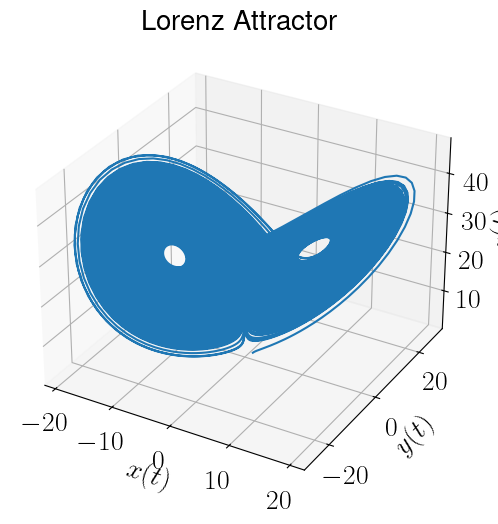

In [150]:
x0 = [1,1,1]
dt = 0.01
Tmax = 1000
# x,y,z,t = evolve(lorenz,Tmax,dt,x0)

with gzip.open(data_dir + 'Lorenz3D Training Data.data', 'rb') as file:
    X = pkl.load(file)
    t = pkl.load(file)

x = X[:,0]
y = X[:,1]
z = X[:,2]



n = len(t)

fontsize = 20

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x,y,z)
ax1.set_xlabel(r'$x(t)$', fontsize=20, rotation=0)
ax1.set_ylabel(r'$y(t)$',fontsize=20)
ax1.set_zlabel(r'$z(t)$', fontsize=20, rotation=60)
ax1.set_title('Lorenz Attractor',fontsize=20)
plt.show()

In [151]:
LE_max = 0.8739

rm_transient = 10000
cutoff = len(t)-rm_transient-int(25*LE_max/dt)-1 #10000 #int(0.95*(len(t)-rm_transient))
future = len(t)-cutoff-rm_transient-1

X = np.vstack((x,y,z)).T
X_train, y_train = lead_data(X[rm_transient:rm_transient+cutoff+1,:])
X_test, y_test = lead_data(X[rm_transient+cutoff+1:,:])

print(rm_transient, cutoff, future, len(t))

10000 87815 2184 100000


In [152]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(87815, 3) (87815, 3)
(2183, 3) (2183, 3)


# RC

In [106]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

In [107]:
rpy.verbosity(0)

0

In [108]:
units = 1000
leak_rate = 0.2
spectral_radius = 1.1
input_scaling = 1.0
connectivity = 0.5
input_connectivity = 0.55
regularization = 1e-6
seed = 1234

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
readout = Ridge(X_train.shape[1], ridge=regularization)

model = reservoir >> readout

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.transform(y_train)
X_test_scaled = scaler.transform(X_test)
y_test_scaled = scaler.transform(y_test)

rc = model.fit(X_train_scaled, y_train_scaled)




# # Train your model and test your model.
# y_pred = model.fit(X_train, y_train) \
#                     .run(X_test)


In [109]:
seed_timesteps = 1000

warming_inputs = X_train_scaled[-seed_timesteps:]

warming_out = rc.run(warming_inputs, reset=True)  # warmup

nb_generations = len(X_test_scaled)

y_pred = np.zeros((nb_generations, X_test_scaled.shape[1]))
y_warm = X_test_scaled[0]#warming_out[-1]
for i in range(nb_generations):  # generation
    y_warm = rc(y_warm)
    y_pred[i, :] = y_warm
#     y_warm = y_test_scaled[i]

y_pred_RC = scaler.inverse_transform(y_pred)

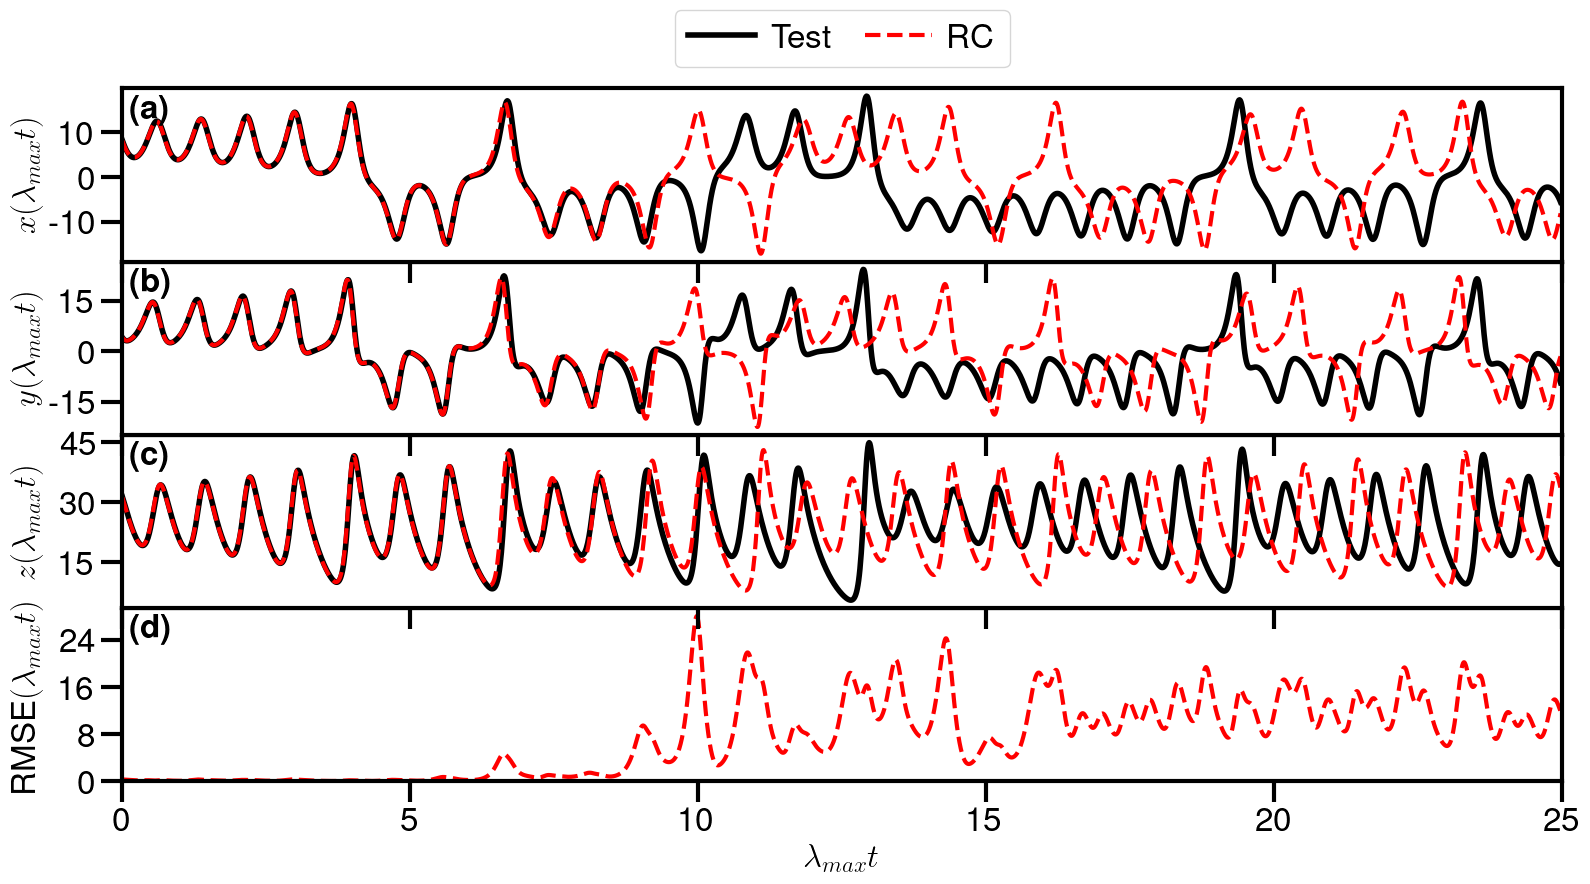

In [110]:
pred_data_lst = [y_pred_RC]
label_lst = ['RC']
color_lst = ['r']
lw_lst = [3]
ls_lst = ['--']
ylabels = ['$x$','$y$','$z$','RMSE']

plot_test_results(y_test, pred_data_lst, label_lst, color_lst, lw_lst, ls_lst,
                  ylabels=ylabels, save_fig=False, fname='',
                  mag_format=False, num_fmt='.0f', LE_max=LE_max, dt=dt)

In [114]:
with gzip.open(data_dir + 'RC_Results.data', 'wb') as file:
    pkl.dump(y_pred_RC, file)

# NG-RC

In [112]:
lead = 1

# time step
dt=0.01
# units of time to warm up NVAR. need to have warmup_pts >= 1
warmup = rm_transient*dt
# warmup = dt*cutoff-10
# units of time to train for
traintime = cutoff*dt
# traintime = 10
# units of time to test for
testtime = future*dt
# total time to run for
maxtime = warmup+traintime+testtime
# how much of testtime to plot
plottime=20.
# Lyapunov time of the Lorenz system
lyaptime=1.104

# discrete-time versions of the times defined above
warmup_pts=round(warmup/dt)
traintime_pts=round(traintime/dt)
warmtrain_pts=warmup_pts+traintime_pts
testtime_pts=round(testtime/dt)
maxtime_pts=round(maxtime/dt)
plottime_pts=round(plottime/dt)
lyaptime_pts=round(lyaptime/dt)

# input dimension
d = 3
# number of time delay taps
k = 25
# size of linear part of feature vector
dlin = k*d
# size of nonlinear part of feature vector
dnonlin = int(dlin*(dlin+1)/2)
# total size of feature vector: constant + linear + nonlinear
dtot = 1 + dlin + dnonlin

# ridge parameter for regression
ridge_param = 2.5e-6

# t values for whole evaluation time
# (need maxtime_pts + 1 to ensure a step of dt)
# t_eval=np.linspace(0,maxtime,maxtime_pts+1)


##
## NVAR
##

# create an array to hold the linear part of the feature vector
x = np.zeros((dlin,maxtime_pts))

# fill in the linear part of the feature vector for all times
for delay in range(k):
    for j in range(delay,maxtime_pts):
        x[d*delay:d*(delay+1),j]=X[j-delay,:]

# create an array to hold the full feature vector for training time
# (use ones so the constant term is already 1)
out_train = np.ones((dtot,traintime_pts))

# copy over the linear part (shift over by one to account for constant)
out_train[1:dlin+1,:]=x[:,warmup_pts-lead:warmtrain_pts-lead]

# fill in the non-linear part
cnt=0
for row in range(dlin):
    for column in range(row,dlin):
        # shift by one for constant
        out_train[dlin+1+cnt]=x[row,warmup_pts-lead:warmtrain_pts-lead]*x[column,warmup_pts-lead:warmtrain_pts-lead]
        cnt += 1

# ridge regression: train W_out to map out_train to Lorenz[t] - Lorenz[t - 1]
W_out = (x[0:d,warmup_pts:warmtrain_pts]-x[0:d,warmup_pts-lead:warmtrain_pts-lead]) @ out_train[:,:].T @ np.linalg.pinv(out_train[:,:] @ out_train[:,:].T + ridge_param*np.identity(dtot))




# X_train, X_test, y_train, y_test = train_test_split(X[:-1], X[1:], train_size=len_train, shuffle=False)
# print(X_train.shape, X_test.shape)

# create a place to store feature vectors for prediction
out_test = np.zeros(dtot)   # full feature vector
x_test = np.zeros((dlin,testtime_pts))   # linear part

y_pred_NGRC = np.zeros(y_test.shape)

# copy over initial linear feature vector
x_test[:,0] = x[:,warmtrain_pts-1]

for j in trange(len(y_pred), leave=False):
    # copy linear part into whole feature vector
    out_test[1:dlin+1]=x_test[:,j] # shift by one for constant
    # fill in the non-linear part
    cnt=0
    for row in range(dlin):
        for column in range(row,dlin):
            # shift by one for constant
            out_test[dlin+1+cnt]=x_test[row,j]*x_test[column,j]
            cnt += 1
    # fill in the delay taps of the next state
    x_test[d:dlin,j+1]=x_test[0:(dlin-d),j]
    # do a prediction
    x_test[0:d,j+1] = x_test[0:d,j]+W_out @ out_test[:]
    
    y_pred_NGRC[j,:] = x_test[:3,j]

# y_pred_NGRC = x_test[:3].T

  0%|          | 0/2183 [00:00<?, ?it/s]

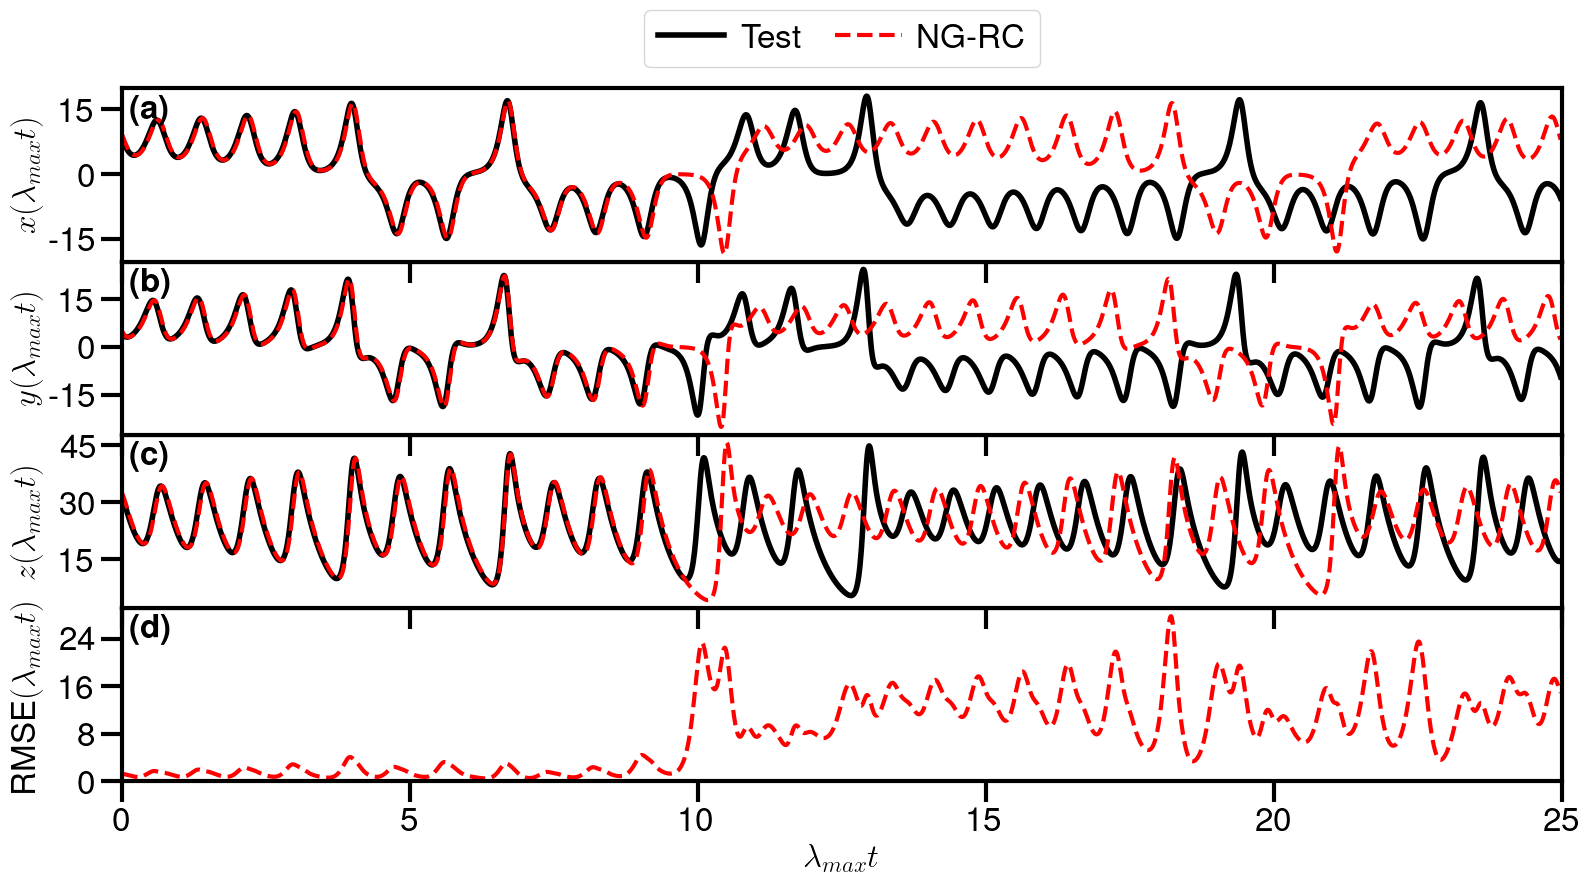

In [113]:
pred_data_lst = [y_pred_NGRC]
label_lst = ['NG-RC']
color_lst = ['r']
lw_lst = [3]
ls_lst = ['--']
ylabels = ['$x$','$y$','$z$','RMSE']

plot_test_results(y_test, pred_data_lst, label_lst, color_lst, lw_lst, ls_lst, 
                  ylabels=ylabels, save_fig=False, fname='', 
                  mag_format=False, num_fmt='.0f', LE_max=LE_max, dt=dt)

In [115]:
with gzip.open(data_dir + 'NGRC_Results.data', 'wb') as file:
    pkl.dump(y_pred_NGRC, file)

# LSTM

In [13]:
import torch as tc
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, warmup, dropout, N, k, device):
        super(LSTMModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.warmup = warmup
        self.dropout = dropout
        self.N = N
        self.k = k

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout if layer_dim>1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)
        
        self.device = device
    def forward(self, x, future=0, training=False):
        # h_n = tc.zeros(1, self.hidden_dim)
        # output = tc.zeros(len(x), self.output_dim)
        # for i in range(len(x)):
        #   out, h_n = self.lstm(x[i:i+1], h_n)
        #   out = self.linear(out)
        #   output[i,:] = out
        # return output
        # h_n = tc.zeros(1, self.hidden_dim)
        # output = tc.zeros(len(x), self.output_dim)
        # for i in range(min(warmup,len(x))):
        #   out, h_n = self.lstm(x[i:i+1], h_n)
        #   out = self.linear(out)
        #   output[i,:] = out

        # # out = x[warmup-1]
        # for i in range(warmup,len(x)):
        #   out, h_n = self.lstm(out.reshape(1,-1), h_n)
        #   out = self.linear(out)
        #   output[i,:] = out
        # return output

        output = tc.zeros(len(x)+future,self.output_dim, device=self.device)

        if training:
            x = self.dropout(x)
        x, (h_n, c_n) = self.lstm(x)
        x = self.linear(x)
        output[:len(x),:] = x

        out = x[-1]
        for i in range(future):
            if training:
                out = self.dropout(out)
            out1, (h_n, c_n) = self.lstm(out.reshape(1,-1), (h_n, c_n))
            out1 = self.linear(out1)
            out = tc.hstack((out.reshape((self.N,self.k))[:,1:],out1.reshape((self.N,self.k))[:,-1].reshape(-1,1))).flatten()
            output[len(x)+i,:] = out


        return output

In [15]:
tc.backends.cuda.matmul.allow_tf32 = True
tc.backends.cudnn.allow_tf32 = True

In [16]:
tc.set_default_dtype(tc.float)

  0%|          | 0/86766 [00:00<?, ?it/s]

  0%|          | 0/86766 [00:00<?, ?it/s]

  0%|          | 0/86766 [00:00<?, ?it/s]

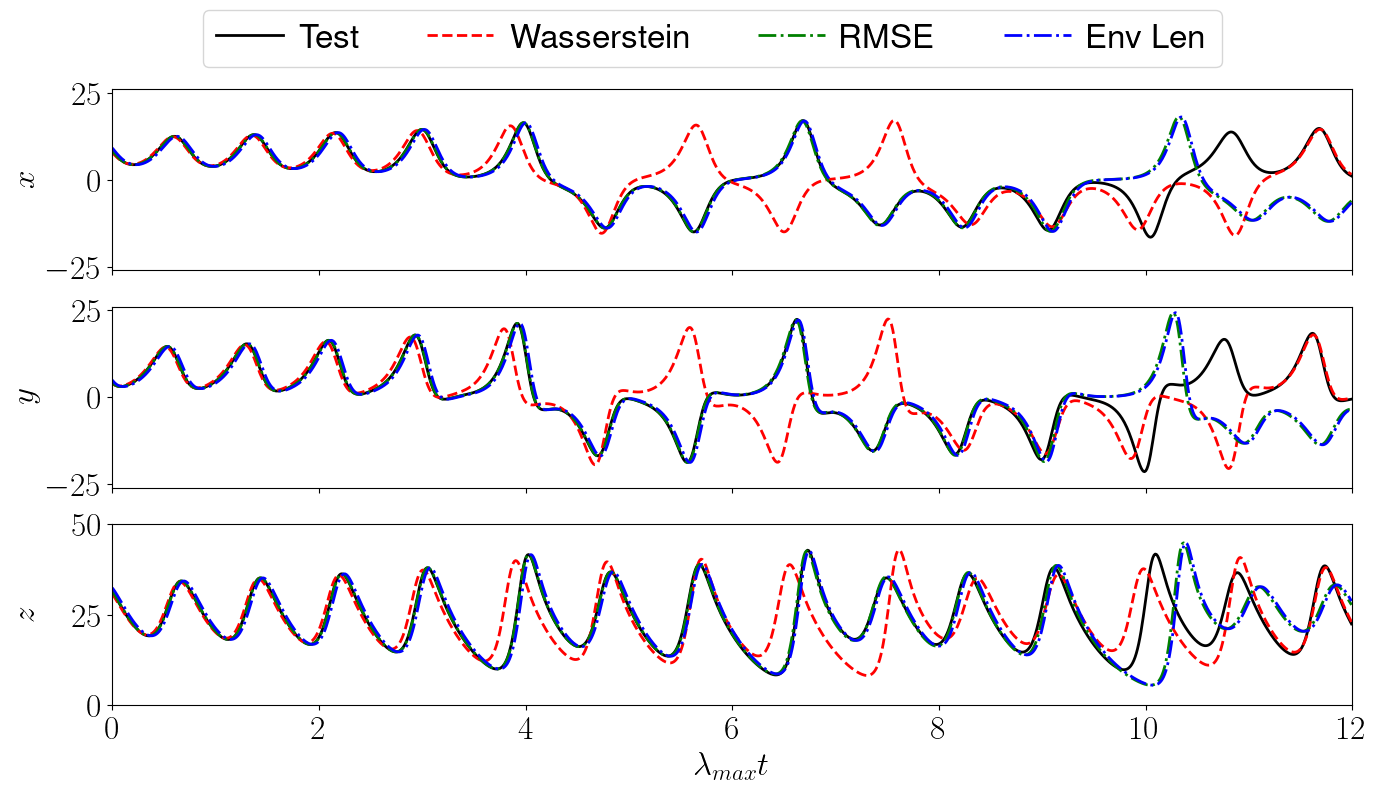

(1048, 3) (1048, 3)


In [17]:
from scipy.stats import wasserstein_distance

LE_max = 0.8739
dt = t[1] - t[0]
t_LE = np.arange(len(X_test))*dt/LE_max

smallest_dist = float('inf')
i_smallest_dist_wass = 0
window_len = np.argmin(np.abs(12-t_LE))
for i in trange(len(X_train)-window_len):
    dist = wasserstein_distance(X_train[i:i+window_len,0],X_test[:window_len,0])
    if dist < smallest_dist:
        i_smallest_dist_wass, smallest_dist = i, dist


smallest_dist = float('inf')
i_smallest_dist_rmse = 0
window_len = np.argmin(np.abs(12-t_LE))
for i in trange(len(X_train)-window_len):
    dist = np.mean(rmse_vec(X_train[i:i+window_len], X_test[:window_len]))
    if dist < smallest_dist:
        i_smallest_dist_rmse, smallest_dist = i, dist


longest_env_len = 0
i_longest_env_len = 0
window_len = np.argmin(np.abs(12-t_LE))
for i in trange(len(X_train)-window_len):
    env_len = envelope_length(X_train[i:i+window_len], X_test[:window_len], threshold=5)
    if env_len > longest_env_len:
        i_longest_env_len, longest_env_len = i, env_len


fontsize = 24
lw = 2

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, axs = plt.subplots(3,1,figsize=(16,8),sharex=True)
ax1, ax2, ax3 = axs

ax1.plot(t_LE[:window_len],X_test[:window_len,0],'k',lw=lw,label='Test')
ax1.plot(t_LE[:window_len],X_train[i_smallest_dist_wass:i_smallest_dist_wass+window_len,0],'r--',lw=lw,label='Wasserstein')
ax1.plot(t_LE[:window_len],X_train[i_smallest_dist_rmse:i_smallest_dist_rmse+window_len,0],'g-.',lw=lw,label='RMSE')
ax1.plot(t_LE[:window_len],X_train[i_longest_env_len:i_longest_env_len+window_len,0],'b-.',lw=lw,label='Env Len')

ax2.plot(t_LE[:window_len],X_test[:window_len,1],'k',lw=lw)
ax2.plot(t_LE[:window_len],X_train[i_smallest_dist_wass:i_smallest_dist_wass+window_len,1],'r--',lw=lw)
ax2.plot(t_LE[:window_len],X_train[i_smallest_dist_rmse:i_smallest_dist_rmse+window_len,1],'g-.',lw=lw)
ax2.plot(t_LE[:window_len],X_train[i_longest_env_len:i_longest_env_len+window_len,1],'b-.',lw=lw)

ax3.plot(t_LE[:window_len],X_test[:window_len,2],'k',lw=lw)
ax3.plot(t_LE[:window_len],X_train[i_smallest_dist_wass:i_smallest_dist_wass+window_len,2],'r--',lw=lw)
ax3.plot(t_LE[:window_len],X_train[i_smallest_dist_rmse:i_smallest_dist_rmse+window_len,2],'g-.',lw=lw)
ax3.plot(t_LE[:window_len],X_train[i_longest_env_len:i_longest_env_len+window_len,2],'b-.',lw=lw)

ax3.set_xlim(0,12)
ax1.set_ylim(-26,26)
ax2.set_ylim(-26,26)
ax3.set_ylim(0,50)

ax3.set_xlabel(r'$\lambda_{max}t$', fontsize=fontsize)
ax1.set_ylabel(r'$x$', fontsize=fontsize)
ax2.set_ylabel(r'$y$', fontsize=fontsize)
ax3.set_ylabel(r'$z$', fontsize=fontsize)

fig.legend(loc='upper center',bbox_to_anchor=(0.5,1),ncol=4,handletextpad=.5,columnspacing=2,prop={'size':fontsize})

fig.align_labels()
# plt.tight_layout()

plt.show()

X_val = X_train[i_longest_env_len:i_longest_env_len+window_len-1]
y_val = X_train[1+i_longest_env_len:i_longest_env_len+window_len]

print(X_val.shape, y_val.shape)

In [99]:
import copy

  0%|          | 0/100 [00:00<?, ?it/s]

Finished epoch   0  |  train 0.39019153  |  test 2.25190244  |  test closed-loop  9.58461048  |  val closed-loop  9.05558350  |  test index 24   (LE 0.275)  |  val index 27   (LE 0.309)  |  lr 0.0001  |  bs 50
New best model ^
Finished epoch   1  |  train 0.02356494  |  test 1.23096317  |  test closed-loop  9.38098571  |  val closed-loop  9.58986153  |  test index 26   (LE 0.298)  |  val index 29   (LE 0.332)  |  lr 0.0001  |  bs 50
New best model ^
Finished epoch   2  |  train 0.01061855  |  test 0.91580472  |  test closed-loop  9.57014029  |  val closed-loop  9.05659787  |  test index 41   (LE 0.469)  |  val index 45   (LE 0.515)  |  lr 0.0001  |  bs 50
New best model ^
Finished epoch   3  |  train 0.00690122  |  test 0.78171303  |  test closed-loop  9.90950062  |  val closed-loop  8.91681709  |  test index 105  (LE 1.202)  |  val index 109  (LE 1.247)  |  lr 0.0001  |  bs 50
New best model ^
Finished epoch   4  |  train 0.00540062  |  test 0.73397837  |  test closed-loop 10.77004916

Finished epoch  39  |  train 0.00292869  |  test 0.61265022  |  test closed-loop 10.03271836  |  val closed-loop  9.97273747  |  test index 179  (LE 2.048)  |  val index 182  (LE 2.083)  |  lr 0.0001  |  bs 50
Finished epoch  40  |  train 0.00293172  |  test 0.62707702  |  test closed-loop  9.22536963  |  val closed-loop  7.11258420  |  test index 328  (LE 3.753)  |  val index 327  (LE 3.742)  |  lr 0.0001  |  bs 50
Finished epoch  41  |  train 0.00298021  |  test 0.59931256  |  test closed-loop 10.87364549  |  val closed-loop  9.46256411  |  test index 236  (LE 2.701)  |  val index 236  (LE 2.701)  |  lr 0.0001  |  bs 50
Finished epoch  42  |  train 0.00307164  |  test 0.61405498  |  test closed-loop  8.62389612  |  val closed-loop  8.52399307  |  test index 168  (LE 1.922)  |  val index 168  (LE 1.922)  |  lr 0.0001  |  bs 50
Finished epoch  43  |  train 0.00295624  |  test 0.58438722  |  test closed-loop  9.25280453  |  val closed-loop  7.38367156  |  test index 308  (LE 3.524)  |  

Finished epoch  79  |  train 0.00293323  |  test 0.59015052  |  test closed-loop 10.39857320  |  val closed-loop  9.07579646  |  test index 105  (LE 1.202)  |  val index 108  (LE 1.236)  |  lr 0.0001  |  bs 50
Finished epoch  80  |  train 0.00286177  |  test 0.57129371  |  test closed-loop 10.03232551  |  val closed-loop 10.06153949  |  test index 173  (LE 1.980)  |  val index 175  (LE 2.003)  |  lr 0.0001  |  bs 50
Finished epoch  81  |  train 0.00296203  |  test 0.61000617  |  test closed-loop 11.19060969  |  val closed-loop 10.11259729  |  test index 164  (LE 1.877)  |  val index 165  (LE 1.888)  |  lr 0.0001  |  bs 50
Finished epoch  82  |  train 0.00289202  |  test 0.61482460  |  test closed-loop  6.47475454  |  val closed-loop  5.27461109  |  test index 531  (LE 6.076)  |  val index 533  (LE 6.099)  |  lr 0.0001  |  bs 50
Finished epoch  83  |  train 0.00290155  |  test 0.59481383  |  test closed-loop  8.24221241  |  val closed-loop  8.13388106  |  test index 327  (LE 3.742)  |  

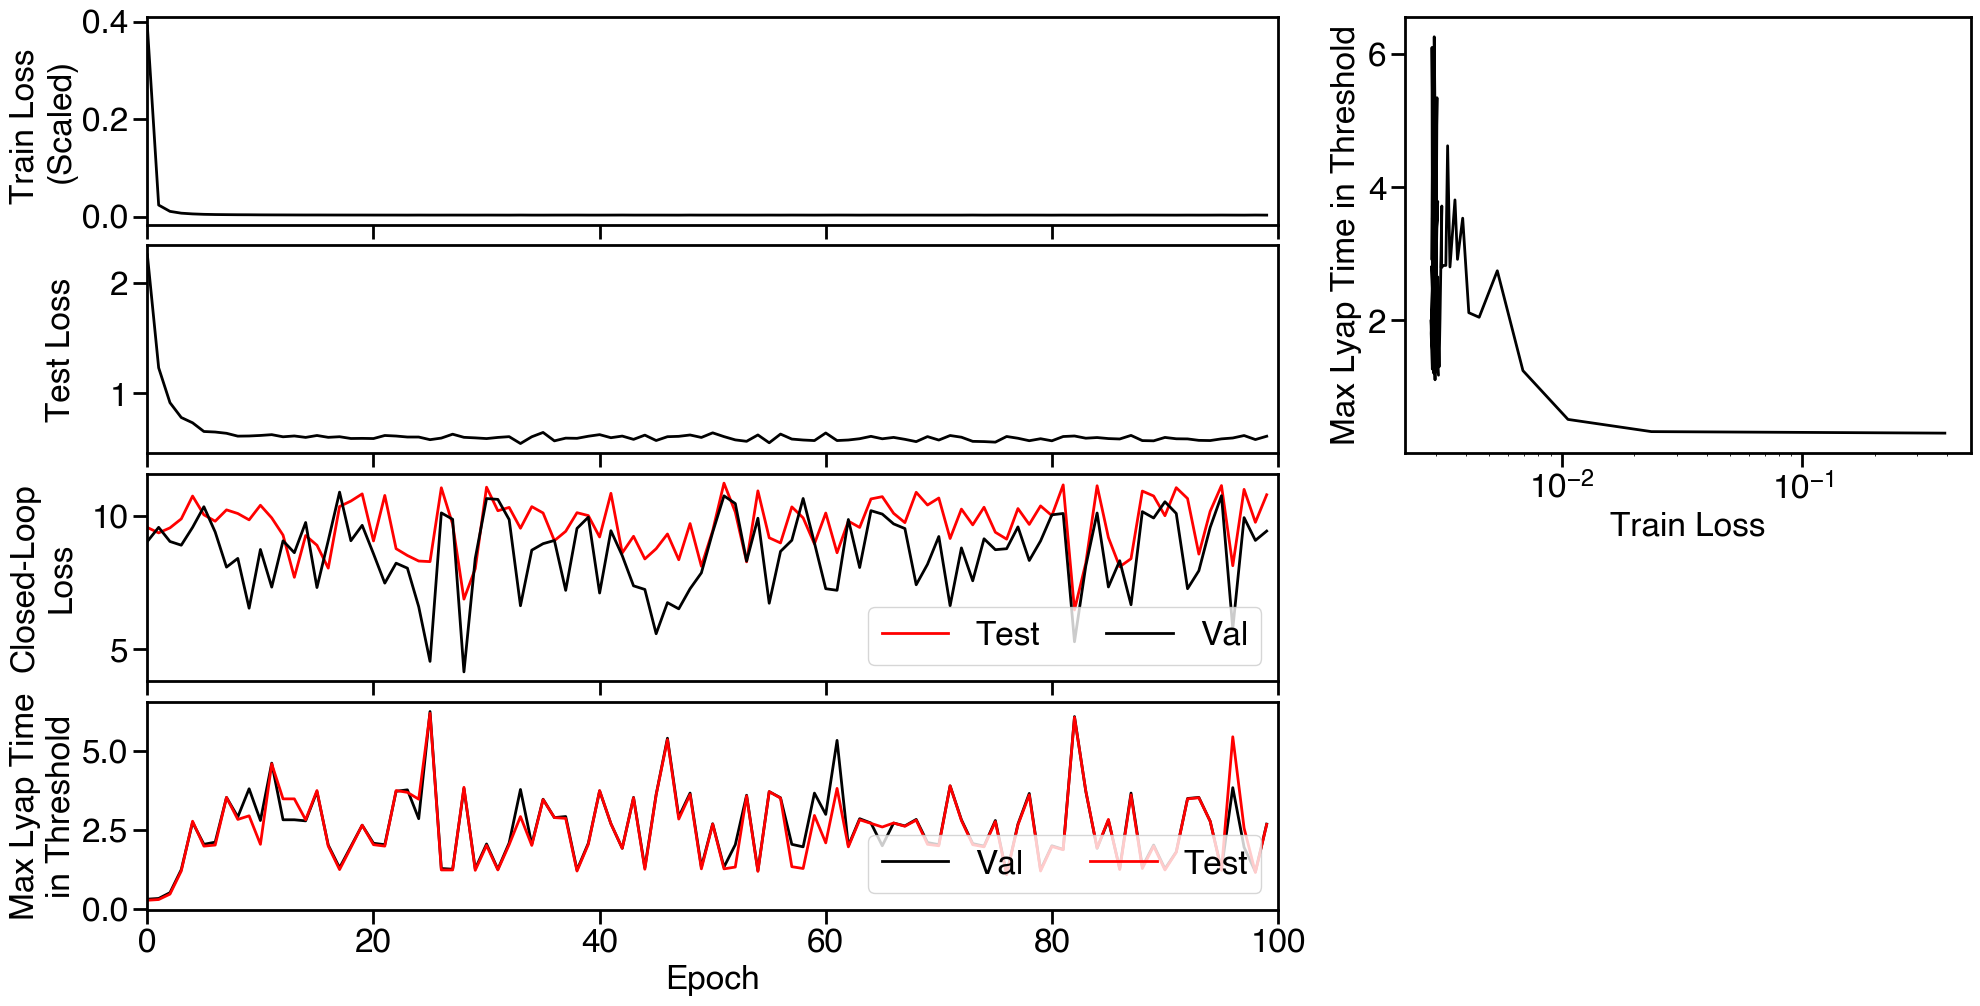

In [106]:
device = tc.device('cuda')

fname = 'LSTM Adam'
save_every = 100

k_LSTM = 10
n = len(X_train)-k_LSTM-1

# features, _ = make_features_and_labels(X_train[:-1].T,k_LSTM,n)
# labels, _ = make_features_and_labels(X_train[1:].T,k_LSTM,n)

# features = np.vstack((make_features_and_labels(X_train[:i_longest_env_len-1].T,k_LSTM,len(X_train[:i_longest_env_len-1])-k_LSTM-1)[0],
#                       make_features_and_labels(X_train[i_longest_env_len+window_len:-1].T,k_LSTM,len(X_train[i_longest_env_len+window_len:-1])-k_LSTM-1)[0]))
# labels = np.vstack((make_features_and_labels(X_train[1:i_longest_env_len].T,k_LSTM,len(X_train[1:i_longest_env_len])-k_LSTM-1)[0],
#                     make_features_and_labels(X_train[1+i_longest_env_len+window_len:].T,k_LSTM,len(X_train[1+i_longest_env_len+window_len:])-k_LSTM-1)[0]))
features = np.vstack((make_features_and_labels(X_train[:i_longest_env_len-1],k_LSTM)[0],
                      make_features_and_labels(X_train[i_longest_env_len+window_len:-1],k_LSTM)[0]))
labels = np.vstack((make_features_and_labels(X_train[1:i_longest_env_len],k_LSTM)[0],
                    make_features_and_labels(X_train[1+i_longest_env_len+window_len:],k_LSTM,)[0]))

N = X_train.shape[1]



num_epochs = 100
batch_size = 50
warmup = 800
dropout = 0.1
num_layers = 1
hidden_size = 500
base_lr = 0.0001
shuffle = True

scaler = StandardScaler()
scaler = scaler.fit(features)

X_train_tensor = tc.tensor(scaler.transform(features), device=device, dtype=tc.float)
y_train_tensor = tc.tensor(scaler.transform(labels), device=device, dtype=tc.float)
X_val_tensor   = tc.tensor(scaler.transform(make_features_and_labels(X_train[:i_longest_env_len-1],k_LSTM)[0]), device=device, dtype=tc.float)
# X_test_tensor = tc.tensor(scaler.transform(X_test), dtype=tc.float)
# y_test_tensor = tc.tensor(scaler.transform(y_test), dtype=tc.float)

# X_val_tensor_w_warmup = tc.tensor(scaler.transform(make_features_and_labels(np.vstack((X_train[-warmup:],X_val)).T, k_LSTM, len(X_val)+warmup-k_LSTM)[0]), dtype=tc.float)
X_test_tensor_w_warmup = tc.tensor(scaler.transform(make_features_and_labels(np.vstack((X_train[-warmup:],X_test)), k_LSTM)[0]), device=device, dtype=tc.float)
# y_test_tensor_w_warmup = tc.tensor(scaler.transform(np.vstack((y_train[-warmup:],y_test))), dtype=tc.float)

# train = TensorDataset(X_train_tensor,y_train_tensor)
# test = TensorDataset(X_test_tensor,y_test_tensor)

# train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
# test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)


model = LSTMModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_LSTM, device)
swa_model = tc.optim.swa_utils.AveragedModel(model)

best_model = copy.deepcopy(model)
# best_model_state_dict = model.state_dict().copy()
# best_model = LSTMModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_LSTM, device)

model.to(device)
best_model.to(device)

loss_fn = nn.MSELoss() #nn.MSELoss()
optimizer = tc.optim.Adam(model.parameters(), lr=base_lr, weight_decay=1e-3)#, momentum=0.09)
# optimizer = tc.optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=1e-3)
optimizer_closed = tc.optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=1e-3)

start = 25
past = 5
mult = 1.5
add = 0.1
bound_lr = 0.8
patience = 20
epoch_lr_updated = start-patience



# past = 5
# thresh = 5
# mult = 1.005
# bound_lr = 1.25
# bound_batch_size = 1000
# patience = 5
# epoch_lr_updated = start - patience
# scheduler = tc.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
scheduler = tc.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.75, patience=10, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0.01, eps=1e-08)

closed_loop_switch = 1e9

swa_start = 30
# swa_scheduler = tc.optim.swa_utils.SWALR(optimizer, swa_lr=0.05, anneal_epochs=10)


model.train()

# X_train_tensor = tc.tensor(X_train, dtype=tc.float)
# y_train_tensor = tc.tensor(y_train, dtype=tc.float)

train_losses = np.zeros((num_epochs,))
test_losses = np.zeros((num_epochs,))
test_losses_closed = np.zeros((num_epochs,))
val_losses_closed = np.zeros((num_epochs,))
# corrdims = np.zeros((num_epochs,))
max_in_thresholds_test = np.zeros((num_epochs,))
max_in_thresholds_val = np.zeros((num_epochs,))

rmse_threshold = 5
LE_max = 0.8739
dt = t[1] - t[0]

test_loss = 1e9
max_in_threshold_val_prev = 0
for epoch in trange(num_epochs):
    loss_tmp = 0
    model.train()
    if epoch > closed_loop_switch:
        if shuffle:
#             lst = tqdm(np.random.permutation(range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup)), desc=str(epoch), leave=False)
            lst = np.random.permutation(range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup))
        else:
#             lst = trange(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup, desc=str(epoch), leave=False)
            lst = range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup)
        for i in lst:
            y_pred = model(X_train_tensor[i:i+warmup], batch_size, training=True)
            #         print(y_pred)
            # loss = loss_fn(y_pred[warmup:], y_train_tensor[i+warmup:i+batch_size+warmup])
            loss = loss_fn(y_pred[warmup:], y_train_tensor[i+warmup:i+batch_size+warmup])
            optimizer_closed.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer_closed.step()
            loss_tmp += loss
        if epoch > start:
            scheduler.step(loss_tmp)
        if epoch > swa_start:
            swa_model.update_parameters(model)
            # swa_scheduler.step(loss)
    else:
        if shuffle:
#             lst = tqdm(np.random.permutation(range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup)), desc=str(epoch), leave=False)
            lst = np.random.permutation(range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup))
        else:
#             lst = trange(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup, desc=str(epoch), leave=False)
            lst = range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup)
        for i in lst:
            y_pred = model(X_train_tensor[i:i+batch_size+warmup], training=True)
            #         print(y_pred)
            # loss = loss_fn(y_pred[warmup:], y_train_tensor[i+warmup:i+batch_size+warmup])
            loss = loss_fn(y_pred, y_train_tensor[i:i+batch_size+warmup])
            optimizer.zero_grad()
            loss.backward()
            # nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            loss_tmp += loss
        if epoch > start:
            scheduler.step(loss_tmp)
        if epoch > swa_start:
            swa_model.update_parameters(model)
    loss_tmp /= len(lst)
    model.eval()
    with tc.no_grad():
        y_pred_closed = np.transpose(scaler.inverse_transform(model(X_train_tensor[-warmup:], len(X_test)).cpu().detach().numpy()).reshape((len(X_test)+warmup,N,k_LSTM)), (0,2,1))[warmup:, -1, :]
        y_out = model(X_test_tensor_w_warmup)
        y_pred = np.transpose(scaler.inverse_transform(y_out.cpu().detach().numpy()).reshape((len(y_out),N,k_LSTM)), (0,2,1))[warmup-k_LSTM:, -1, :]

        y_pred_closed_val = np.transpose(scaler.inverse_transform(model(X_val_tensor[-warmup:], len(X_val)).cpu().detach().numpy()).reshape((len(X_val)+warmup,N,k_LSTM)), (0,2,1))[warmup:, -1, :]

        # warming_inputs = tc.tensor(scaler.transform(features[-warmup:]), dtype=tc.float)
        # warming_out = tc.zeros(warmup, labels.shape[1])

        # h_n = tc.zeros(1, model.hidden_dim)
        # for i in range(warmup):
        #   out, h_n = model.lstm(warming_inputs[i:i+1], h_n)
        #   out = model.linear(out)
        #   warming_out[i,:] = out

        # y_pred = tc.zeros(y_test.shape)
        # y_warm = warming_out[-1]
        # for i in range(len(X_test)):  # generation
        #     # y_warm = model(y_warm.reshape(1,-1))
        #     y_warm, h_n = model.lstm(y_warm.reshape(1,-1), h_n)
        #     y_warm = model.linear(y_warm)
        #     y_pred[i, :] = y_warm
        # y_pred = scaler.inverse_transform(y_pred)
        # y_pred = model(X_test_tensor_w_warmup)
        # test_loss = loss_fn(y_pred, y_test_tensor_w_warmup[warmup:])
        # y_pred = scaler.inverse_transform(y_pred.detach().numpy())
        prev_test_loss = test_loss
        test_loss = np.mean(rmse(y_test[:,0],y_test[:,1],y_test[:,2],y_pred[:,0],y_pred[:,1],y_pred[:,2],0,0))
        error_signal = rmse(y_test[:,0],y_test[:,1],y_test[:,2],y_pred_closed[:,0],y_pred_closed[:,1],y_pred_closed[:,2],0,0)
        test_loss_closed = np.mean(error_signal)
        max_in_threshold_test = np.argmax(error_signal > rmse_threshold)


        error_signal = rmse(y_val[:,0],y_val[:,1],y_val[:,2],y_pred_closed_val[:,0],y_pred_closed_val[:,1],y_pred_closed_val[:,2],0,0)
        val_loss_closed = np.mean(error_signal)
        max_in_threshold_val = np.argmax(error_signal > rmse_threshold)

#       emb_dim = 2
#       tau = 1

#       embedding = delay_embedding_multidimensional(y_pred_closed.T, emb_dim, tau=tau)

#       corrint = skdim.id.CorrInt()
#       corrint.fit(embedding)
#       corrdim = corrint.dimension_


        train_losses[epoch] = loss_tmp
        test_losses[epoch] = test_loss
        test_losses_closed[epoch] = test_loss_closed
        val_losses_closed[epoch] = val_loss_closed
        #       corrdims[epoch] = corrdim
        max_in_thresholds_test[epoch] = max_in_threshold_test
        max_in_thresholds_val[epoch] = max_in_threshold_val
    if epoch > start:
        # scheduler.step(max_in_threshold_val)

        if np.max(max_in_thresholds_val[epoch-past+1:epoch+1] - max_in_thresholds_val[epoch-past:epoch]) == 0 and epoch > epoch_lr_updated + patience:
            epoch_lr_updated = epoch
            for g in optimizer.param_groups:
#                 if add < 0:
#                     g['lr'] = max(add+g['lr'], bound_lr)
#                 else:
#                     g['lr'] = min(add+g['lr'], bound_lr)
                if mult < 1:
                    g['lr'] = max(mult*g['lr'], bound_lr)
                else:
                    g['lr'] = min(mult*g['lr'], bound_lr)
        elif max_in_thresholds_val[epoch] < max_in_thresholds_val[epoch-1]:
            epoch_lr_updated = epoch
            for g in optimizer.param_groups:
                g['lr'] = base_lr


        # if max_in_thresholds_val[epoch] <= max(max_in_thresholds_val[epoch-past:epoch]) + thresh and epoch > epoch_lr_updated + patience:
        #   epoch_lr_updated = epoch
        #   if optimizer.param_groups[0]['lr'] == bound_lr:
        #     if mult < 1:
        #       batch_size = min(int(batch_size/mult), bound_batch_size)
        #     else:
        #       batch_size = max(int(batch_size/mult), bound_batch_size)
        #   else:
        #     for g in optimizer.param_groups:
        #       if mult < 1:
        #         g['lr'] = max(mult*g['lr'], bound_lr)
        #       else:
        #         g['lr'] = min(mult*g['lr'], bound_lr)

    print('Finished epoch {:>3}  |  train {:10.8f}  |  test {:10.8f}  |  test closed-loop {:11.8f}  |  val closed-loop {:11.8f}  |  test index {:<4} (LE {:5.3f})  |  val index {:<4} (LE {:5.3f})  |  lr {:.4f}  |  bs {:}'.format(epoch, loss_tmp, test_loss, test_loss_closed,
                                                                                                                                                                                                                              val_loss_closed,
                                                                                                                                                                                                                              max_in_threshold_test,
                                                                                                                                                                                                                              max_in_threshold_test*dt/LE_max,
                                                                                                                                                                                                                              max_in_threshold_val,
                                                                                                                                                                                                                              max_in_threshold_val*dt/LE_max,
                                                                                                                                                                                                                              optimizer.param_groups[0]['lr'],
                                                                                                                                                                                                                              batch_size))
                                                                                                                                                                                                                              # scheduler.get_last_lr() if epoch > start else optimizer.param_groups[0]['lr']))
    # if test_loss > prev_test_loss*1.05:
    #   break

    if max_in_threshold_val > max_in_threshold_val_prev:
#         best_model_state_dict = model.state_dict().copy()
        max_in_threshold_val_prev = max_in_threshold_val
        best_model = copy.deepcopy(model)
#         best_model.load_state_dict(best_model_state_dict)
        print('New best model ^')

    if epoch % save_every == 0:
#         tc.save(best_model_state_dict, data_dir+fname+'_best.pt')
#         best_model = LSTMModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_LSTM, device=device)
#         best_model.load_state_dict(best_model_state_dict.copy())
        with gzip.open(data_dir + fname + '.data', 'wb') as file:
            pkl.dump(best_model, file)
            pkl.dump(model, file)
            pkl.dump(train_losses, file)
            pkl.dump(test_losses, file)
            pkl.dump(test_losses_closed, file)
            pkl.dump(val_losses_closed, file)
            #         pkl.dump(corrdim, file)
            #         pkl.dump(corrdims, file)
            pkl.dump(max_in_thresholds_test, file)
            pkl.dump(max_in_thresholds_val, file)

model.eval()


fontsize = 24
lw = 2
plt.rc('text', usetex=False)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, axs = plt.subplots(4,2,figsize=(20,10),gridspec_kw={'width_ratios':[2,1]})
for i in range(4):
    for j in range(2):
        plt.setp(axs[i,j].get_xticklabels(), visible=False)
        plt.setp(axs[i,j].get_yticklabels(), visible=False)
        axs[i,j].tick_params(length=0,width=0)
ax1 = plt.subplot2grid(shape=(4, 2), loc=(0, 0))
ax2 = plt.subplot2grid(shape=(4, 2), loc=(1, 0), sharex=ax1)
ax3 = plt.subplot2grid(shape=(4, 2), loc=(2, 0), sharex=ax2)
ax4 = plt.subplot2grid(shape=(4, 2), loc=(3, 0), sharex=ax3)
ax5 = plt.subplot2grid(shape=(4, 2), loc=(0, 1), rowspan=2)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
axs[2, 1].axis('off')
axs[3, 1].axis('off')

ax1.plot(train_losses, 'k', lw=lw, label=r'Train')

ax2.plot(test_losses, 'k', lw=lw)

ax3.plot(test_losses_closed, 'r', lw=lw, label=r'Test')
ax3.plot(val_losses_closed, 'k', lw=lw, label=r'Val')
# emb_dim = 2
# tau = 1

# embedding = delay_embedding_multidimensional(X_train.T, emb_dim, tau=tau)

# corrint = skdim.id.CorrInt()
# corrint.fit(embedding)
# corrdim = corrint.dimension_

# ax3.axhline(corrdim, c='k', lw=lw, label='True')

# ax3.plot(corrdims, 'r', lw=lw, label='Predicted')



ax4.plot(max_in_thresholds_val*dt/LE_max, 'k', lw=lw, label='Val')
ax4.plot(max_in_thresholds_test*dt/LE_max, 'r', lw=lw, label='Test')

# ax2.set_xlim(0,num_epochs)
# ax2.set_xlabel(r'Epoch', fontsize=fontsize)
ax4.set_xlim(0,num_epochs)
ax4.set_xlabel(r'Epoch', fontsize=fontsize)

ax1.set_ylabel('Train Loss \n(Scaled)', fontsize=fontsize)
ax2.set_ylabel('Test Loss', fontsize=fontsize)
ax3.set_ylabel('Closed-Loop\nLoss', fontsize=fontsize)
ax4.set_ylabel('Max Lyap Time\nin Threshold', fontsize=fontsize)

# ax1.legend(loc='lower right', ncols=2, prop={'size': fontsize})
# ax2.legend(loc='lower right', ncols=2, prop={'size': fontsize})
ax3.legend(loc='lower right', ncols=2, prop={'size': fontsize})
ax4.legend(loc='lower right', ncols=2, prop={'size': fontsize})

# ax5 = plt.subplot(1,3,2)
ax5.plot(train_losses,max_in_thresholds_val*dt/LE_max,'k',lw=lw)

ax5.set_xscale('log')

ax5.set_xlabel('Train Loss', fontsize=fontsize)
ax5.set_ylabel('Max Lyap Time in Threshold', fontsize=fontsize)


plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.1)
fig.align_labels([ax1,ax2,ax3,ax4,ax5])

plt.setp(ax1.spines.values(), linewidth=2)
plt.setp(ax2.spines.values(), linewidth=2)
plt.setp(ax3.spines.values(), linewidth=2)
plt.setp(ax4.spines.values(), linewidth=2)
plt.setp(ax5.spines.values(), linewidth=2)
ax1.tick_params(length=10,width=2)
ax2.tick_params(length=10,width=2)
ax3.tick_params(length=10,width=2)
ax4.tick_params(length=10,width=2)
ax5.tick_params(length=10,width=2)

plt.show()


# best_model = LSTMModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_LSTM, device=device)
# best_model.load_state_dict(best_model_state_dict.copy())
with gzip.open(data_dir + fname + '.data', 'wb') as file:
    pkl.dump(best_model, file)
    pkl.dump(model, file)
    pkl.dump(train_losses, file)
    pkl.dump(test_losses, file)
    pkl.dump(test_losses_closed, file)
    pkl.dump(val_losses_closed, file)
    #   pkl.dump(corrdim, file)
    #   pkl.dump(corrdims, file)
    pkl.dump(max_in_thresholds_test, file)
    pkl.dump(max_in_thresholds_val, file)

In [107]:
warmup_len = warmup

best_model.to(device)
best_model.eval()
with tc.no_grad():
    y_pred_LSTM = np.transpose(scaler.inverse_transform(best_model(X_train_tensor[-warmup_len:], len(X_test)).cpu().detach().numpy()).reshape((len(X_test)+warmup_len,N,k_LSTM)), (0,2,1))[warmup_len:, -1, :]

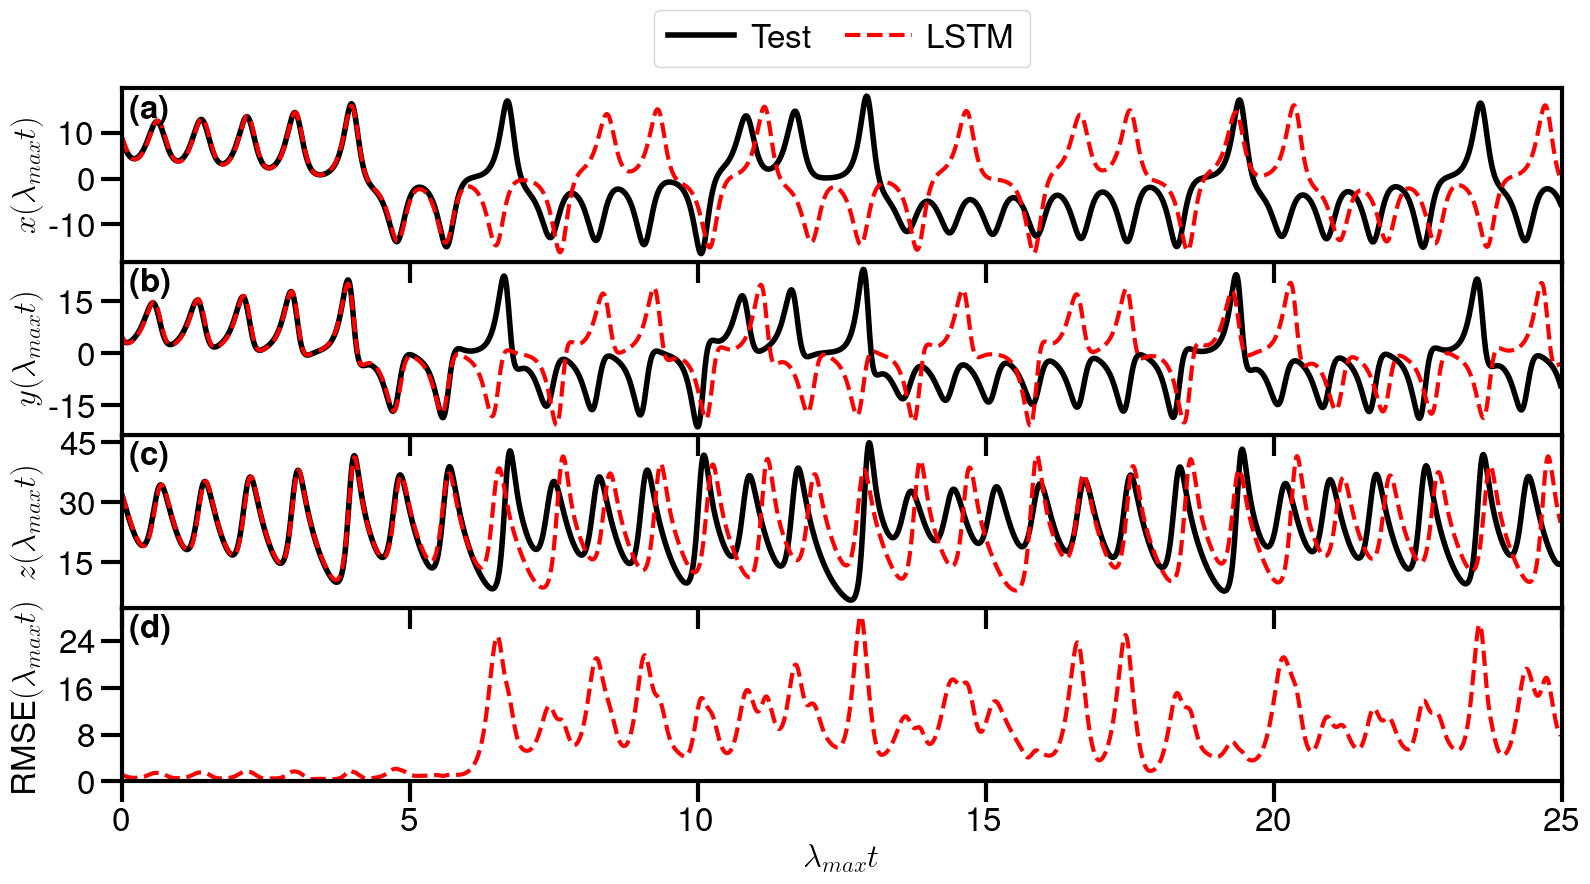

In [108]:
pred_data_lst = [y_pred_LSTM]
label_lst = ['LSTM']
color_lst = ['r']
lw_lst = [3]
ls_lst = ['--']
ylabels = ['$x$','$y$','$z$','RMSE']

plot_test_results(y_test, pred_data_lst, label_lst, color_lst, lw_lst, ls_lst, ylabels=ylabels, save_fig=False, fname='', mag_format=False, num_fmt='.0f', LE_max=LE_max, dt=dt)

In [109]:
with gzip.open(data_dir + 'LSTM_Results.data', 'wb') as file:
    pkl.dump(y_pred_LSTM, file)

# RNN

In [110]:
import torch as tc
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [111]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, warmup, dropout, N, k, device):
        super(RNNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.warmup = warmup
        self.dropout = dropout
        self.N = N
        self.k = k

        # self.rnn = nn.RNNCell(input_dim, hidden_dim, nonlinearity='tanh')
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout if layer_dim>1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

        self.device = device
    def forward(self, x, future=0, training=False):
        # output = tc.zeros(len(x)+future, self.output_dim)
        # n_samples = len(x)

        # h_n = tc.zeros(1, self.hidden_dim)
        # # h_n = self.rnn(x, h_n)
        # # out = self.linear(h_n)
        # # output[:n_samples,:] = out
        # # out = out[-1]
        # for (i, input_t) in enumerate(x.split(1, dim=0)):
        #   h_n = self.rnn(input_t, h_n)
        #   out = self.linear(h_n)
        #   output[i,:] = out

        # for i in range(future):
        #   h_n = self.rnn(out, h_n)
        #   out = self.linear(h_n)
        #   output[n_samples+i,:] = out

        # return output


        output = tc.zeros(len(x)+future,self.output_dim, device=self.device)

        if training:
            x = self.dropout(x)
        x, h_n = self.rnn(x)
        x = self.linear(x)
        output[:len(x),:] = x

        out = x[-1]
        for i in range(future):
            if training:
                out = self.dropout(out)
            out1, h_n = self.rnn(out.reshape(1,-1), h_n)
            out1 = self.linear(out1)
            out = tc.hstack((out.reshape((self.N,self.k))[:,1:],out1.reshape((self.N,self.k))[:,-1].reshape(-1,1))).flatten()
            output[len(x)+i,:] = out

        return output

In [112]:
tc.backends.cuda.matmul.allow_tf32 = True
tc.backends.cudnn.allow_tf32 = True

In [113]:
tc.set_default_dtype(tc.float)

  0%|          | 0/87247 [00:00<?, ?it/s]

  0%|          | 0/87247 [00:00<?, ?it/s]

  0%|          | 0/87247 [00:00<?, ?it/s]

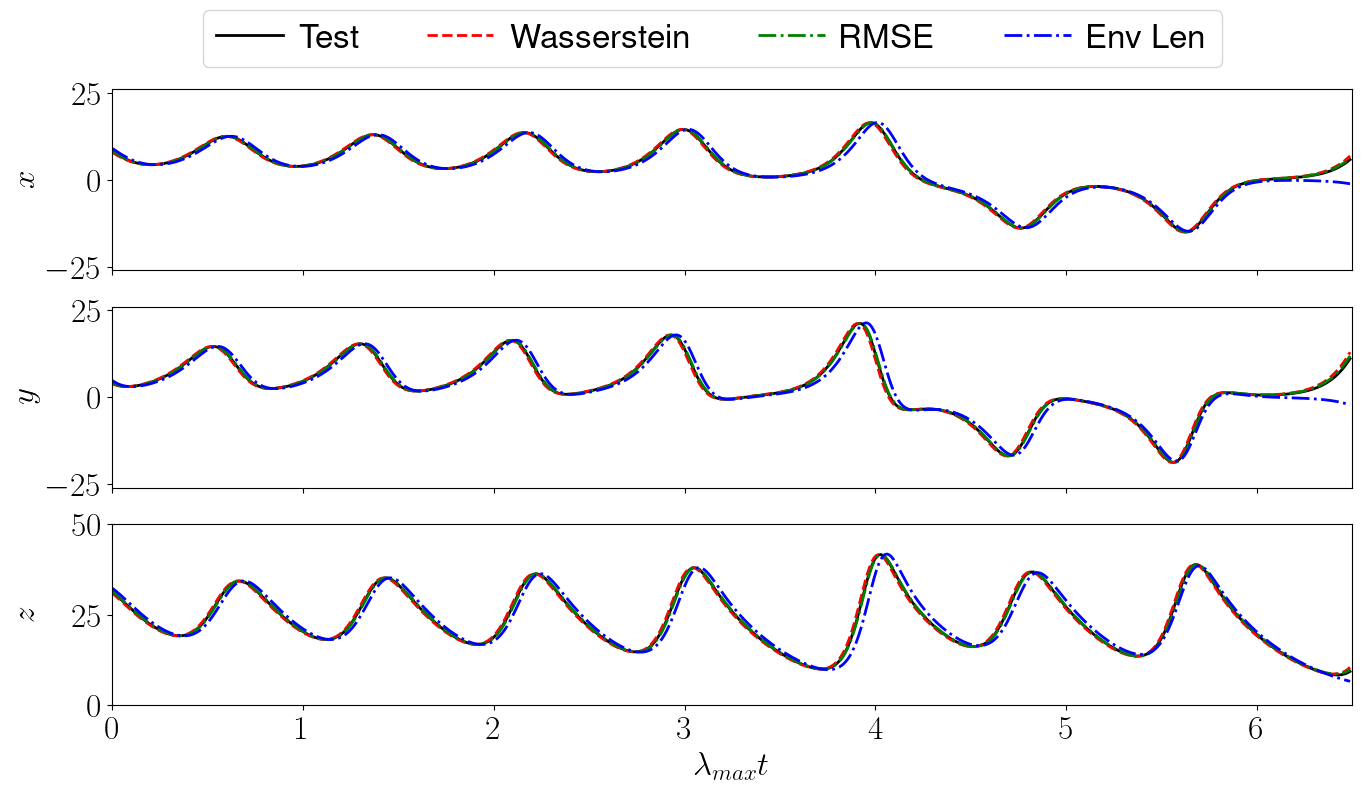

(567, 3) (567, 3)


In [114]:
from scipy.stats import wasserstein_distance

LE_max = 0.8739
dt = t[1] - t[0]
t_LE = np.arange(len(X_test))*dt/LE_max

smallest_dist = float('inf')
i_smallest_dist_wass = 0
window_len = np.argmin(np.abs(6.5-t_LE))
for i in trange(len(X_train)-window_len):
    dist = wasserstein_distance(X_train[i:i+window_len,0],X_test[:window_len,0])
    if dist < smallest_dist:
        i_smallest_dist_wass, smallest_dist = i, dist


smallest_dist = float('inf')
i_smallest_dist_rmse = 0
window_len = np.argmin(np.abs(6.5-t_LE))
for i in trange(len(X_train)-window_len):
    dist = np.mean(rmse_vec(X_train[i:i+window_len], X_test[:window_len]))
    if dist < smallest_dist:
        i_smallest_dist_rmse, smallest_dist = i, dist


longest_env_len = 0
i_longest_env_len = 0
window_len = np.argmin(np.abs(6.5-t_LE))
for i in trange(len(X_train)-window_len):
    env_len = envelope_length(X_train[i:i+window_len], X_test[:window_len], threshold=5)
    if env_len > longest_env_len:
        i_longest_env_len, longest_env_len = i, env_len


fontsize = 24
lw = 2

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, axs = plt.subplots(3,1,figsize=(16,8),sharex=True)
ax1, ax2, ax3 = axs

ax1.plot(t_LE[:window_len],X_test[:window_len,0],'k',lw=lw,label='Test')
ax1.plot(t_LE[:window_len],X_train[i_smallest_dist_wass:i_smallest_dist_wass+window_len,0],'r--',lw=lw,label='Wasserstein')
ax1.plot(t_LE[:window_len],X_train[i_smallest_dist_rmse:i_smallest_dist_rmse+window_len,0],'g-.',lw=lw,label='RMSE')
ax1.plot(t_LE[:window_len],X_train[i_longest_env_len:i_longest_env_len+window_len,0],'b-.',lw=lw,label='Env Len')

ax2.plot(t_LE[:window_len],X_test[:window_len,1],'k',lw=lw)
ax2.plot(t_LE[:window_len],X_train[i_smallest_dist_wass:i_smallest_dist_wass+window_len,1],'r--',lw=lw)
ax2.plot(t_LE[:window_len],X_train[i_smallest_dist_rmse:i_smallest_dist_rmse+window_len,1],'g-.',lw=lw)
ax2.plot(t_LE[:window_len],X_train[i_longest_env_len:i_longest_env_len+window_len,1],'b-.',lw=lw)

ax3.plot(t_LE[:window_len],X_test[:window_len,2],'k',lw=lw)
ax3.plot(t_LE[:window_len],X_train[i_smallest_dist_wass:i_smallest_dist_wass+window_len,2],'r--',lw=lw)
ax3.plot(t_LE[:window_len],X_train[i_smallest_dist_rmse:i_smallest_dist_rmse+window_len,2],'g-.',lw=lw)
ax3.plot(t_LE[:window_len],X_train[i_longest_env_len:i_longest_env_len+window_len,2],'b-.',lw=lw)

ax3.set_xlim(0,6.5)
ax1.set_ylim(-26,26)
ax2.set_ylim(-26,26)
ax3.set_ylim(0,50)

ax3.set_xlabel(r'$\lambda_{max}t$', fontsize=fontsize)
ax1.set_ylabel(r'$x$', fontsize=fontsize)
ax2.set_ylabel(r'$y$', fontsize=fontsize)
ax3.set_ylabel(r'$z$', fontsize=fontsize)

fig.legend(loc='upper center',bbox_to_anchor=(0.5,1),ncol=4,handletextpad=.5,columnspacing=2,prop={'size':fontsize})

fig.align_labels()
# plt.tight_layout()

plt.show()

X_val = X_train[i_longest_env_len:i_longest_env_len+window_len-1]
y_val = X_train[1+i_longest_env_len:i_longest_env_len+window_len]

print(X_val.shape, y_val.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

Finished epoch   0  |  train 0.22020341  |  test 2.24740751  |  test closed-loop  8.13159641  |  val closed-loop  7.51237503  |  test index 19   (LE 0.217)  |  val index 22   (LE 0.252)  |  lr 0.0001  |  bs 50
New best model ^
Finished epoch   1  |  train 0.02411583  |  test 1.25651520  |  test closed-loop 10.79098613  |  val closed-loop  8.02838171  |  test index 27   (LE 0.309)  |  val index 28   (LE 0.320)  |  lr 0.0001  |  bs 50
New best model ^
Finished epoch   2  |  train 0.01187041  |  test 0.83541788  |  test closed-loop 11.01503283  |  val closed-loop  6.64420552  |  test index 318  (LE 3.639)  |  val index 318  (LE 3.639)  |  lr 0.0001  |  bs 50
New best model ^
Finished epoch   3  |  train 0.00893698  |  test 0.71295730  |  test closed-loop 11.52670495  |  val closed-loop  6.25701641  |  test index 176  (LE 2.014)  |  val index 255  (LE 2.918)  |  lr 0.0001  |  bs 50
Finished epoch   4  |  train 0.00778737  |  test 0.66333165  |  test closed-loop 10.27341910  |  val closed-l

Finished epoch  39  |  train 0.00376345  |  test 0.62199146  |  test closed-loop 11.43064857  |  val closed-loop  7.30339264  |  test index 224  (LE 2.563)  |  val index 193  (LE 2.208)  |  lr 0.0001  |  bs 50
Finished epoch  40  |  train 0.00374910  |  test 0.59256381  |  test closed-loop 11.87499836  |  val closed-loop  9.16453417  |  test index 94   (LE 1.076)  |  val index 95   (LE 1.087)  |  lr 0.0001  |  bs 50
Finished epoch  41  |  train 0.00391094  |  test 0.60491421  |  test closed-loop 11.82681241  |  val closed-loop  8.59143027  |  test index 83   (LE 0.950)  |  val index 83   (LE 0.950)  |  lr 0.0001  |  bs 50
Finished epoch  42  |  train 0.00369706  |  test 0.58836407  |  test closed-loop 10.75520333  |  val closed-loop  7.28255427  |  test index 190  (LE 2.174)  |  val index 192  (LE 2.197)  |  lr 0.0001  |  bs 50
Finished epoch  43  |  train 0.00375829  |  test 0.61506629  |  test closed-loop 11.18495091  |  val closed-loop  8.63033796  |  test index 101  (LE 1.156)  |  

Finished epoch  79  |  train 0.00351112  |  test 0.56693156  |  test closed-loop 11.30292531  |  val closed-loop  8.41711386  |  test index 98   (LE 1.121)  |  val index 98   (LE 1.121)  |  lr 0.0001  |  bs 50
Finished epoch  80  |  train 0.00345054  |  test 0.59942357  |  test closed-loop 10.69618452  |  val closed-loop  7.89743241  |  test index 44   (LE 0.503)  |  val index 48   (LE 0.549)  |  lr 0.0001  |  bs 50
Finished epoch  81  |  train 0.00345480  |  test 0.62888561  |  test closed-loop 10.96001725  |  val closed-loop  7.50069794  |  test index 224  (LE 2.563)  |  val index 172  (LE 1.968)  |  lr 0.0001  |  bs 50
Finished epoch  82  |  train 0.00350435  |  test 0.55574802  |  test closed-loop 10.88901881  |  val closed-loop  7.67132522  |  test index 157  (LE 1.797)  |  val index 158  (LE 1.808)  |  lr 0.0001  |  bs 50
Finished epoch  83  |  train 0.00342521  |  test 0.57798360  |  test closed-loop 10.70455216  |  val closed-loop  7.37826898  |  test index 189  (LE 2.163)  |  

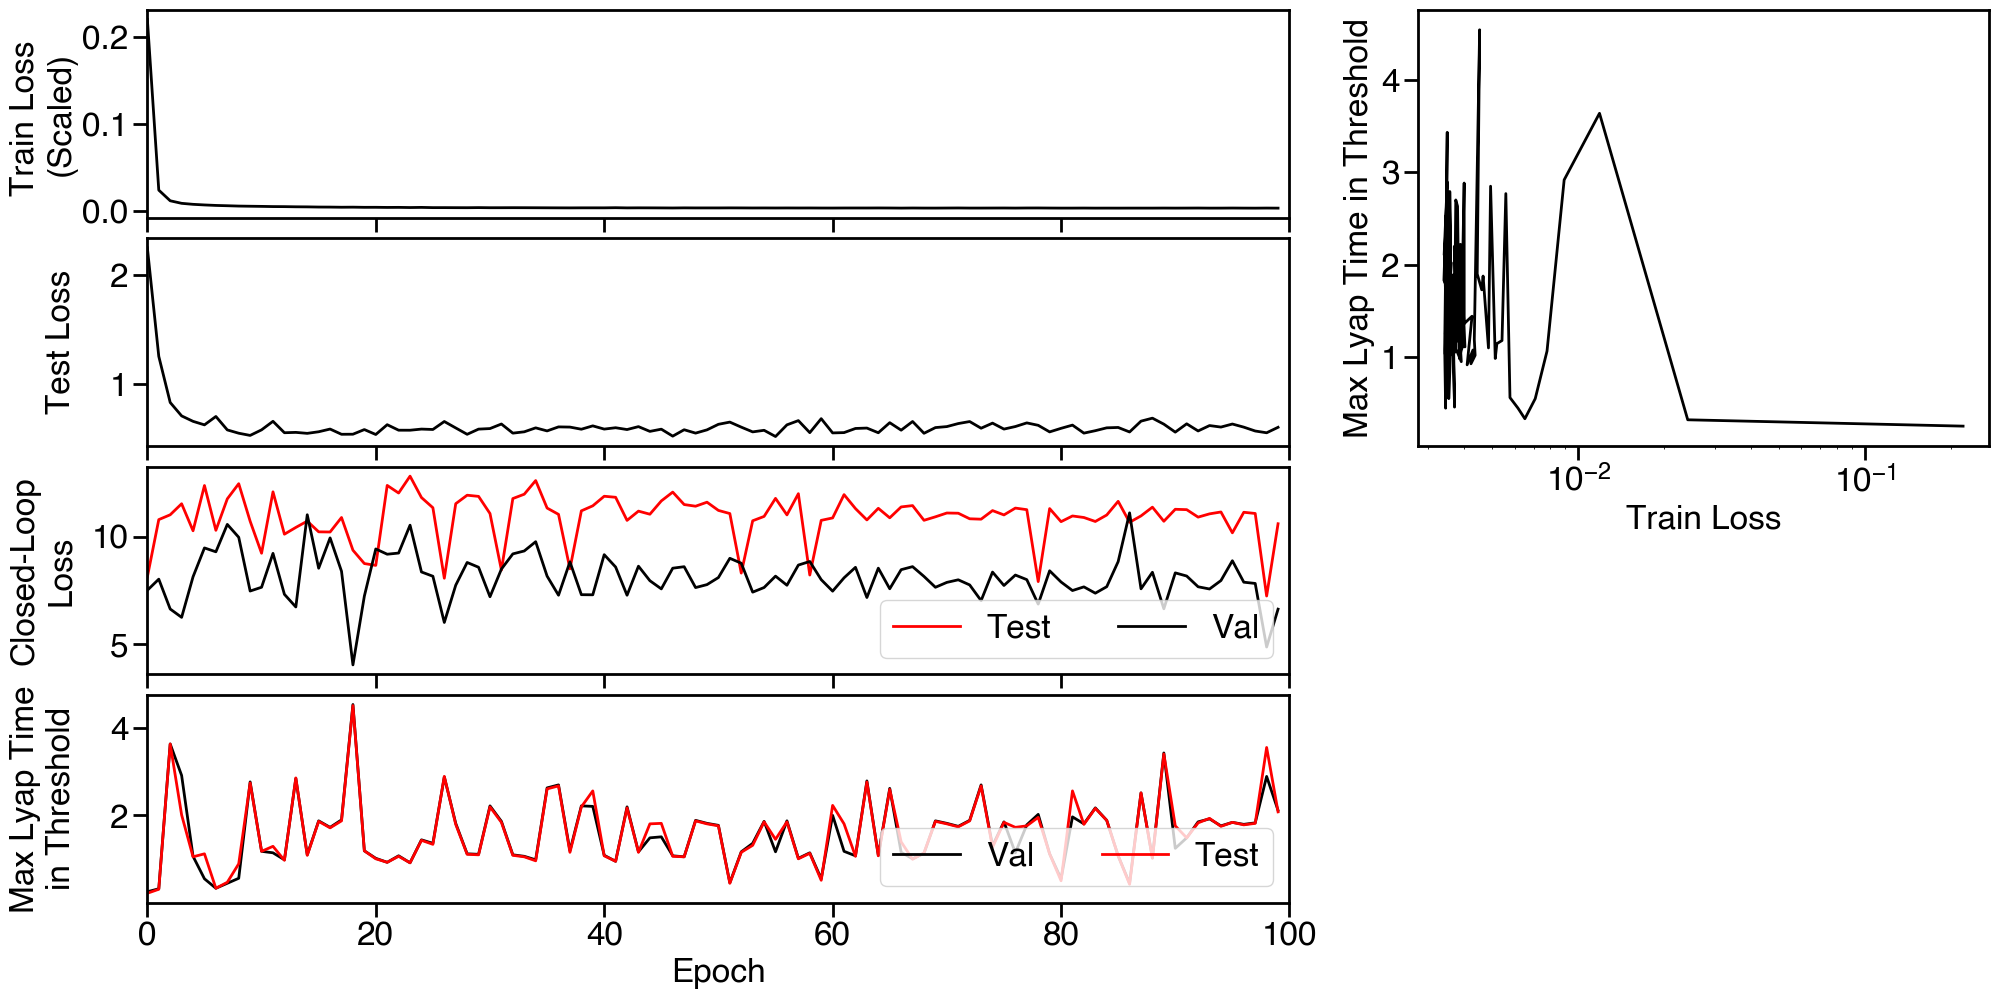

In [129]:
device = tc.device('cuda')

fname = 'RNN Adam'
save_every = 100

k_RNN = 10
n = len(X_train)-k_RNN-1

# features, _ = make_features_and_labels(X_train[:-1].T,k_RNN,n)
# labels, _ = make_features_and_labels(X_train[1:].T,k_RNN,n)

# features = np.vstack((make_features_and_labels(X_train[:i_longest_env_len-1].T,k_RNN,len(X_train[:i_longest_env_len-1])-k_RNN-1)[0],
#                       make_features_and_labels(X_train[i_longest_env_len+window_len:-1].T,k_RNN,len(X_train[i_longest_env_len+window_len:-1])-k_RNN-1)[0]))
# labels = np.vstack((make_features_and_labels(X_train[1:i_longest_env_len].T,k_RNN,len(X_train[1:i_longest_env_len])-k_RNN-1)[0],
#                     make_features_and_labels(X_train[1+i_longest_env_len+window_len:].T,k_RNN,len(X_train[1+i_longest_env_len+window_len:])-k_RNN-1)[0]))
features = np.vstack((make_features_and_labels(X_train[:i_longest_env_len-1],k_RNN)[0],
                      make_features_and_labels(X_train[i_longest_env_len+window_len:-1],k_RNN)[0]))
labels = np.vstack((make_features_and_labels(X_train[1:i_longest_env_len],k_RNN)[0],
                    make_features_and_labels(X_train[1+i_longest_env_len+window_len:],k_RNN,)[0]))

N = X_train.shape[1]



num_epochs = 100
batch_size = 50
warmup = 800
dropout = 0.1
num_layers = 1
hidden_size = 500
base_lr = 0.0001
shuffle = True

scaler = StandardScaler()
scaler = scaler.fit(features)

X_train_tensor = tc.tensor(scaler.transform(features), device=device, dtype=tc.float)
y_train_tensor = tc.tensor(scaler.transform(labels), device=device, dtype=tc.float)
X_val_tensor   = tc.tensor(scaler.transform(make_features_and_labels(X_train[:i_longest_env_len-1],k_RNN)[0]), device=device, dtype=tc.float)
# X_test_tensor = tc.tensor(scaler.transform(X_test), dtype=tc.float)
# y_test_tensor = tc.tensor(scaler.transform(y_test), dtype=tc.float)

# X_val_tensor_w_warmup = tc.tensor(scaler.transform(make_features_and_labels(np.vstack((X_train[-warmup:],X_val)).T, k_RNN, len(X_val)+warmup-k_RNN)[0]), dtype=tc.float)
X_test_tensor_w_warmup = tc.tensor(scaler.transform(make_features_and_labels(np.vstack((X_train[-warmup:],X_test)), k_RNN)[0]), device=device, dtype=tc.float)
# y_test_tensor_w_warmup = tc.tensor(scaler.transform(np.vstack((y_train[-warmup:],y_test))), dtype=tc.float)

# train = TensorDataset(X_train_tensor,y_train_tensor)
# test = TensorDataset(X_test_tensor,y_test_tensor)

# train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
# test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)


model = RNNModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_RNN, device)
swa_model = tc.optim.swa_utils.AveragedModel(model)

best_model = copy.deepcopy(model)
# best_model_state_dict = model.state_dict().copy()
# best_model = RNNModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_RNN, device)

model.to(device)
best_model.to(device)

loss_fn = nn.MSELoss() #nn.MSELoss()
optimizer = tc.optim.Adam(model.parameters(), lr=base_lr, weight_decay=1e-3)#, momentum=0.09)
# optimizer = tc.optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=1e-3)
optimizer_closed = tc.optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=1e-3)

start = 25
past = 5
mult = 1.5
add = 0.1
bound_lr = 0.8
patience = 20
epoch_lr_updated = start-patience



# past = 5
# thresh = 5
# mult = 1.005
# bound_lr = 1.25
# bound_batch_size = 1000
# patience = 5
# epoch_lr_updated = start - patience
# scheduler = tc.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
scheduler = tc.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.75, patience=10, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0.01, eps=1e-08)

closed_loop_switch = 1e9

swa_start = 30
# swa_scheduler = tc.optim.swa_utils.SWALR(optimizer, swa_lr=0.05, anneal_epochs=10)


model.train()

# X_train_tensor = tc.tensor(X_train, dtype=tc.float)
# y_train_tensor = tc.tensor(y_train, dtype=tc.float)

train_losses = np.zeros((num_epochs,))
test_losses = np.zeros((num_epochs,))
test_losses_closed = np.zeros((num_epochs,))
val_losses_closed = np.zeros((num_epochs,))
# corrdims = np.zeros((num_epochs,))
max_in_thresholds_test = np.zeros((num_epochs,))
max_in_thresholds_val = np.zeros((num_epochs,))

rmse_threshold = 5
LE_max = 0.8739
dt = t[1] - t[0]

test_loss = 1e9
max_in_threshold_val_prev = 0
for epoch in trange(num_epochs):
    loss_tmp = 0
    model.train()
    if epoch > closed_loop_switch:
        if shuffle:
#             lst = tqdm(np.random.permutation(range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup)), desc=str(epoch), leave=False)
            lst = np.random.permutation(range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup))
        else:
#             lst = trange(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup, desc=str(epoch), leave=False)
            lst = range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup)
        for i in lst:
            y_pred = model(X_train_tensor[i:i+warmup], batch_size, training=True)
            #         print(y_pred)
            # loss = loss_fn(y_pred[warmup:], y_train_tensor[i+warmup:i+batch_size+warmup])
            loss = loss_fn(y_pred[warmup:], y_train_tensor[i+warmup:i+batch_size+warmup])
            optimizer_closed.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer_closed.step()
            loss_tmp += loss
        if epoch > start:
            scheduler.step(loss_tmp)
        if epoch > swa_start:
            swa_model.update_parameters(model)
            # swa_scheduler.step(loss)
    else:
        if shuffle:
#             lst = tqdm(np.random.permutation(range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup)), desc=str(epoch), leave=False)
            lst = np.random.permutation(range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup))
        else:
#             lst = trange(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup, desc=str(epoch), leave=False)
            lst = range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup)
        for i in lst:
            y_pred = model(X_train_tensor[i:i+batch_size+warmup], training=True)
            #         print(y_pred)
            # loss = loss_fn(y_pred[warmup:], y_train_tensor[i+warmup:i+batch_size+warmup])
            loss = loss_fn(y_pred, y_train_tensor[i:i+batch_size+warmup])
            optimizer.zero_grad()
            loss.backward()
            # nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            loss_tmp += loss
        if epoch > start:
            scheduler.step(loss_tmp)
        if epoch > swa_start:
            swa_model.update_parameters(model)
    loss_tmp /= len(lst)
    model.eval()
    with tc.no_grad():
        y_pred_closed = np.transpose(scaler.inverse_transform(model(X_train_tensor[-warmup:], len(X_test)).cpu().detach().numpy()).reshape((len(X_test)+warmup,N,k_RNN)), (0,2,1))[warmup:, -1, :]
        y_out = model(X_test_tensor_w_warmup)
        y_pred = np.transpose(scaler.inverse_transform(y_out.cpu().detach().numpy()).reshape((len(y_out),N,k_RNN)), (0,2,1))[warmup-k_RNN:, -1, :]

        y_pred_closed_val = np.transpose(scaler.inverse_transform(model(X_val_tensor[-warmup:], len(X_val)).cpu().detach().numpy()).reshape((len(X_val)+warmup,N,k_RNN)), (0,2,1))[warmup:, -1, :]

        # warming_inputs = tc.tensor(scaler.transform(features[-warmup:]), dtype=tc.float)
        # warming_out = tc.zeros(warmup, labels.shape[1])

        # h_n = tc.zeros(1, model.hidden_dim)
        # for i in range(warmup):
        #   out, h_n = model.RNN(warming_inputs[i:i+1], h_n)
        #   out = model.linear(out)
        #   warming_out[i,:] = out

        # y_pred = tc.zeros(y_test.shape)
        # y_warm = warming_out[-1]
        # for i in range(len(X_test)):  # generation
        #     # y_warm = model(y_warm.reshape(1,-1))
        #     y_warm, h_n = model.RNN(y_warm.reshape(1,-1), h_n)
        #     y_warm = model.linear(y_warm)
        #     y_pred[i, :] = y_warm
        # y_pred = scaler.inverse_transform(y_pred)
        # y_pred = model(X_test_tensor_w_warmup)
        # test_loss = loss_fn(y_pred, y_test_tensor_w_warmup[warmup:])
        # y_pred = scaler.inverse_transform(y_pred.detach().numpy())
        prev_test_loss = test_loss
        test_loss = np.mean(rmse(y_test[:,0],y_test[:,1],y_test[:,2],y_pred[:,0],y_pred[:,1],y_pred[:,2],0,0))
        error_signal = rmse(y_test[:,0],y_test[:,1],y_test[:,2],y_pred_closed[:,0],y_pred_closed[:,1],y_pred_closed[:,2],0,0)
        test_loss_closed = np.mean(error_signal)
        max_in_threshold_test = np.argmax(error_signal > rmse_threshold)


        error_signal = rmse(y_val[:,0],y_val[:,1],y_val[:,2],y_pred_closed_val[:,0],y_pred_closed_val[:,1],y_pred_closed_val[:,2],0,0)
        val_loss_closed = np.mean(error_signal)
        max_in_threshold_val = np.argmax(error_signal > rmse_threshold)

#       emb_dim = 2
#       tau = 1

#       embedding = delay_embedding_multidimensional(y_pred_closed.T, emb_dim, tau=tau)

#       corrint = skdim.id.CorrInt()
#       corrint.fit(embedding)
#       corrdim = corrint.dimension_


        train_losses[epoch] = loss_tmp
        test_losses[epoch] = test_loss
        test_losses_closed[epoch] = test_loss_closed
        val_losses_closed[epoch] = val_loss_closed
        #       corrdims[epoch] = corrdim
        max_in_thresholds_test[epoch] = max_in_threshold_test
        max_in_thresholds_val[epoch] = max_in_threshold_val
    if epoch > start:
        # scheduler.step(max_in_threshold_val)

        if np.max(max_in_thresholds_val[epoch-past+1:epoch+1] - max_in_thresholds_val[epoch-past:epoch]) == 0 and epoch > epoch_lr_updated + patience:
            epoch_lr_updated = epoch
            for g in optimizer.param_groups:
#                 if add < 0:
#                     g['lr'] = max(add+g['lr'], bound_lr)
#                 else:
#                     g['lr'] = min(add+g['lr'], bound_lr)
                if mult < 1:
                    g['lr'] = max(mult*g['lr'], bound_lr)
                else:
                    g['lr'] = min(mult*g['lr'], bound_lr)
        elif max_in_thresholds_val[epoch] < max_in_thresholds_val[epoch-1]:
            epoch_lr_updated = epoch
            for g in optimizer.param_groups:
                g['lr'] = base_lr


        # if max_in_thresholds_val[epoch] <= max(max_in_thresholds_val[epoch-past:epoch]) + thresh and epoch > epoch_lr_updated + patience:
        #   epoch_lr_updated = epoch
        #   if optimizer.param_groups[0]['lr'] == bound_lr:
        #     if mult < 1:
        #       batch_size = min(int(batch_size/mult), bound_batch_size)
        #     else:
        #       batch_size = max(int(batch_size/mult), bound_batch_size)
        #   else:
        #     for g in optimizer.param_groups:
        #       if mult < 1:
        #         g['lr'] = max(mult*g['lr'], bound_lr)
        #       else:
        #         g['lr'] = min(mult*g['lr'], bound_lr)

    print('Finished epoch {:>3}  |  train {:10.8f}  |  test {:10.8f}  |  test closed-loop {:11.8f}  |  val closed-loop {:11.8f}  |  test index {:<4} (LE {:5.3f})  |  val index {:<4} (LE {:5.3f})  |  lr {:.4f}  |  bs {:}'.format(epoch, loss_tmp, test_loss, test_loss_closed,
                                                                                                                                                                                                                              val_loss_closed,
                                                                                                                                                                                                                              max_in_threshold_test,
                                                                                                                                                                                                                              max_in_threshold_test*dt/LE_max,
                                                                                                                                                                                                                              max_in_threshold_val,
                                                                                                                                                                                                                              max_in_threshold_val*dt/LE_max,
                                                                                                                                                                                                                              optimizer.param_groups[0]['lr'],
                                                                                                                                                                                                                              batch_size))
                                                                                                                                                                                                                              # scheduler.get_last_lr() if epoch > start else optimizer.param_groups[0]['lr']))
    # if test_loss > prev_test_loss*1.05:
    #   break

    if max_in_threshold_val > max_in_threshold_val_prev:
#         best_model_state_dict = model.state_dict().copy()
        max_in_threshold_val_prev = max_in_threshold_val
        best_model = copy.deepcopy(model)
#         best_model.load_state_dict(best_model_state_dict)
        print('New best model ^')

    if epoch % save_every == 0:
#         tc.save(best_model_state_dict, data_dir+fname+'_best.pt')
#         best_model = RNNModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_RNN, device=device)
#         best_model.load_state_dict(best_model_state_dict.copy())
        with gzip.open(data_dir + fname + '.data', 'wb') as file:
            pkl.dump(best_model, file)
            pkl.dump(model, file)
            pkl.dump(train_losses, file)
            pkl.dump(test_losses, file)
            pkl.dump(test_losses_closed, file)
            pkl.dump(val_losses_closed, file)
            #         pkl.dump(corrdim, file)
            #         pkl.dump(corrdims, file)
            pkl.dump(max_in_thresholds_test, file)
            pkl.dump(max_in_thresholds_val, file)

model.eval()


fontsize = 24
lw = 2
plt.rc('text', usetex=False)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, axs = plt.subplots(4,2,figsize=(20,10),gridspec_kw={'width_ratios':[2,1]})
for i in range(4):
    for j in range(2):
        plt.setp(axs[i,j].get_xticklabels(), visible=False)
        plt.setp(axs[i,j].get_yticklabels(), visible=False)
        axs[i,j].tick_params(length=0,width=0)
ax1 = plt.subplot2grid(shape=(4, 2), loc=(0, 0))
ax2 = plt.subplot2grid(shape=(4, 2), loc=(1, 0), sharex=ax1)
ax3 = plt.subplot2grid(shape=(4, 2), loc=(2, 0), sharex=ax2)
ax4 = plt.subplot2grid(shape=(4, 2), loc=(3, 0), sharex=ax3)
ax5 = plt.subplot2grid(shape=(4, 2), loc=(0, 1), rowspan=2)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
axs[2, 1].axis('off')
axs[3, 1].axis('off')

ax1.plot(train_losses, 'k', lw=lw, label=r'Train')

ax2.plot(test_losses, 'k', lw=lw)

ax3.plot(test_losses_closed, 'r', lw=lw, label=r'Test')
ax3.plot(val_losses_closed, 'k', lw=lw, label=r'Val')
# emb_dim = 2
# tau = 1

# embedding = delay_embedding_multidimensional(X_train.T, emb_dim, tau=tau)

# corrint = skdim.id.CorrInt()
# corrint.fit(embedding)
# corrdim = corrint.dimension_

# ax3.axhline(corrdim, c='k', lw=lw, label='True')

# ax3.plot(corrdims, 'r', lw=lw, label='Predicted')



ax4.plot(max_in_thresholds_val*dt/LE_max, 'k', lw=lw, label='Val')
ax4.plot(max_in_thresholds_test*dt/LE_max, 'r', lw=lw, label='Test')

# ax2.set_xlim(0,num_epochs)
# ax2.set_xlabel(r'Epoch', fontsize=fontsize)
ax4.set_xlim(0,num_epochs)
ax4.set_xlabel(r'Epoch', fontsize=fontsize)

ax1.set_ylabel('Train Loss \n(Scaled)', fontsize=fontsize)
ax2.set_ylabel('Test Loss', fontsize=fontsize)
ax3.set_ylabel('Closed-Loop\nLoss', fontsize=fontsize)
ax4.set_ylabel('Max Lyap Time\nin Threshold', fontsize=fontsize)

# ax1.legend(loc='lower right', ncols=2, prop={'size': fontsize})
# ax2.legend(loc='lower right', ncols=2, prop={'size': fontsize})
ax3.legend(loc='lower right', ncols=2, prop={'size': fontsize})
ax4.legend(loc='lower right', ncols=2, prop={'size': fontsize})

# ax5 = plt.subplot(1,3,2)
ax5.plot(train_losses,max_in_thresholds_val*dt/LE_max,'k',lw=lw)

ax5.set_xscale('log')

ax5.set_xlabel('Train Loss', fontsize=fontsize)
ax5.set_ylabel('Max Lyap Time in Threshold', fontsize=fontsize)


plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.1)
fig.align_labels([ax1,ax2,ax3,ax4,ax5])

plt.setp(ax1.spines.values(), linewidth=2)
plt.setp(ax2.spines.values(), linewidth=2)
plt.setp(ax3.spines.values(), linewidth=2)
plt.setp(ax4.spines.values(), linewidth=2)
plt.setp(ax5.spines.values(), linewidth=2)
ax1.tick_params(length=10,width=2)
ax2.tick_params(length=10,width=2)
ax3.tick_params(length=10,width=2)
ax4.tick_params(length=10,width=2)
ax5.tick_params(length=10,width=2)

plt.show()


# best_model = RNNModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_RNN, device=device)
# best_model.load_state_dict(best_model_state_dict.copy())
with gzip.open(data_dir + fname + '.data', 'wb') as file:
    pkl.dump(best_model, file)
    pkl.dump(model, file)
    pkl.dump(train_losses, file)
    pkl.dump(test_losses, file)
    pkl.dump(test_losses_closed, file)
    pkl.dump(val_losses_closed, file)
    #   pkl.dump(corrdim, file)
    #   pkl.dump(corrdims, file)
    pkl.dump(max_in_thresholds_test, file)
    pkl.dump(max_in_thresholds_val, file)

In [130]:
warmup_len = warmup

best_model.to(device)
best_model.eval()
with tc.no_grad():
    y_pred_RNN = np.transpose(scaler.inverse_transform(best_model(X_train_tensor[-warmup_len:], len(X_test)).cpu().detach().numpy()).reshape((len(X_test)+warmup_len,N,k_LSTM)), (0,2,1))[warmup_len:, -1, :]

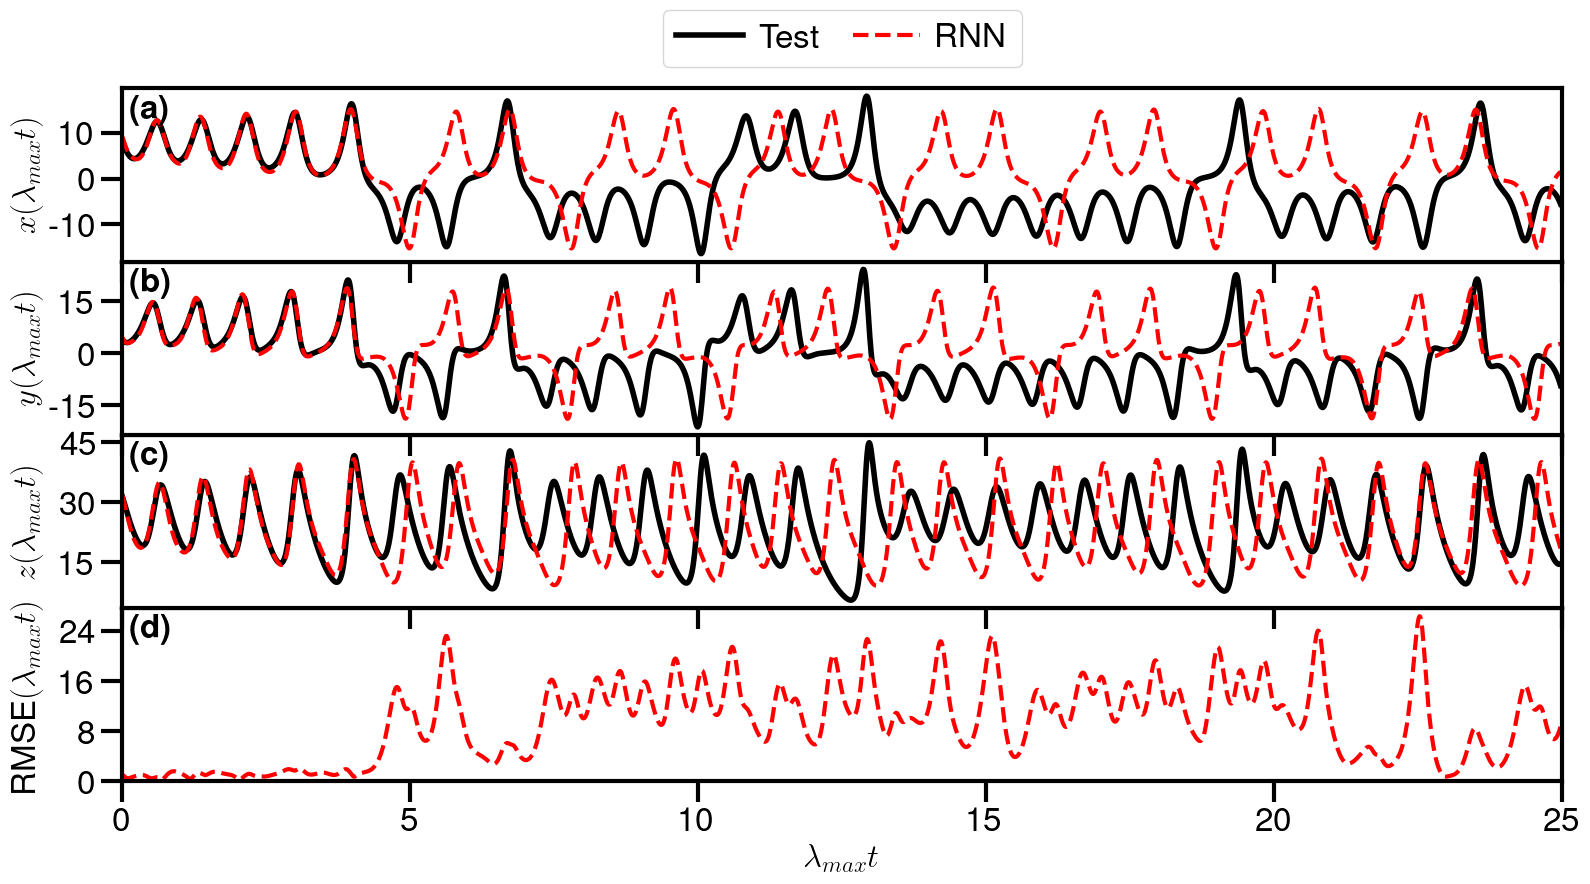

In [131]:
pred_data_lst = [y_pred_RNN]
label_lst = ['RNN']
color_lst = ['r']
lw_lst = [3]
ls_lst = ['--']
ylabels = ['$x$','$y$','$z$','RMSE']

plot_test_results(y_test, pred_data_lst, label_lst, color_lst, lw_lst, ls_lst, ylabels=ylabels, save_fig=False, fname='', mag_format=False, num_fmt='.0f', LE_max=LE_max, dt=dt)

In [132]:
with gzip.open(data_dir + 'RNN_Results.data', 'wb') as file:
    pkl.dump(y_pred_RNN, file)

# TreeDOX

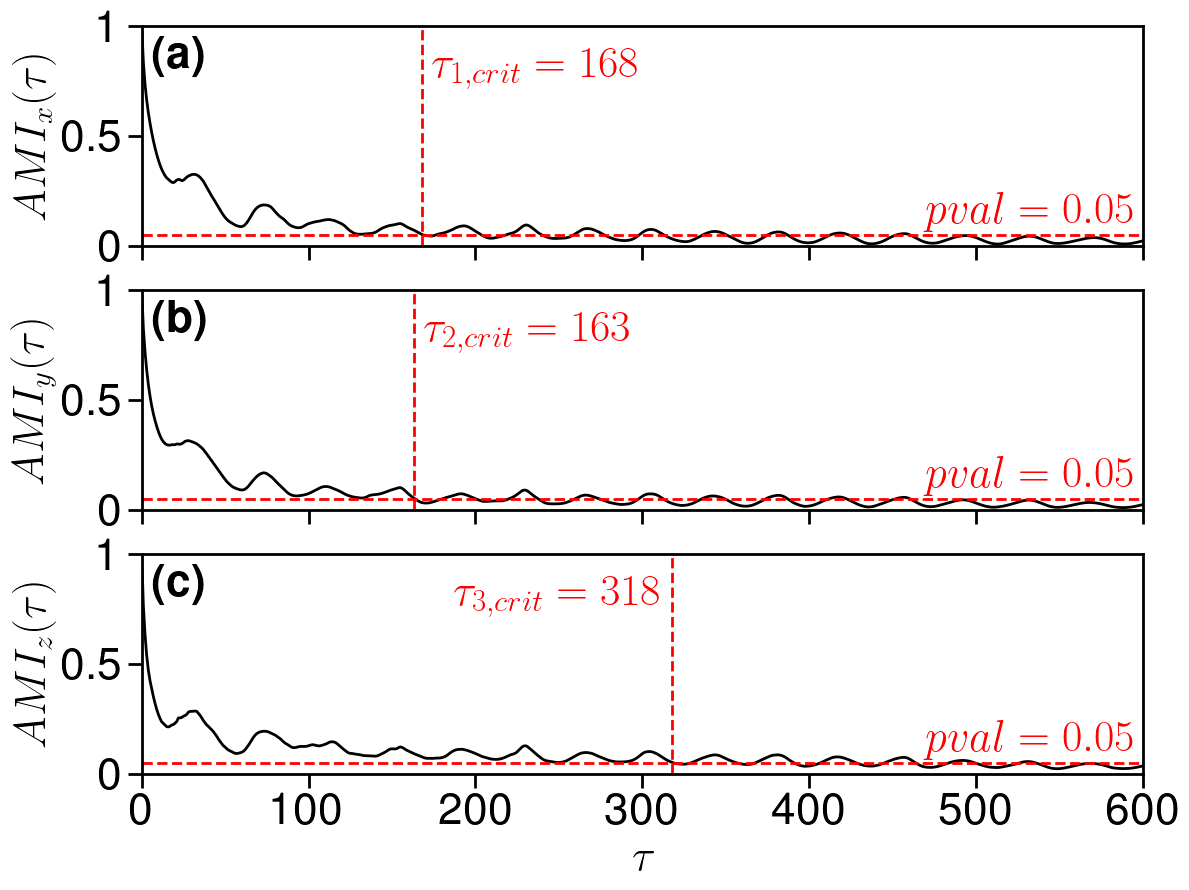

In [204]:
tau_crits = get_tau_crits(X_train, p_val=0.05, max_lag=600, make_plot=True, save_fig=True, fname='AMI')

In [158]:
xi = 1
k = int(np.ceil(max(tau_crits)/xi + 1))
print(f'xi = {xi}, k = {k}')

features, labels = make_features_and_labels(X_train, k, xi=xi, stride=1, lead=1)
print(features.shape, labels.shape)

xi = 1, k = 319
(87496, 957) (87496, 3)


In [159]:
FIs, time_elapsed = feature_selection(features, labels, n_estimators=20, max_depth=None, random_state=None,
                                      n_jobs=-1, n_samples=None, model_type='ETR', verbose=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  1.4min remaining:   28.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.5min finished


Training time: 00 hours, 01 minutes, 32.921497 seconds
RAM Used: 293.7M


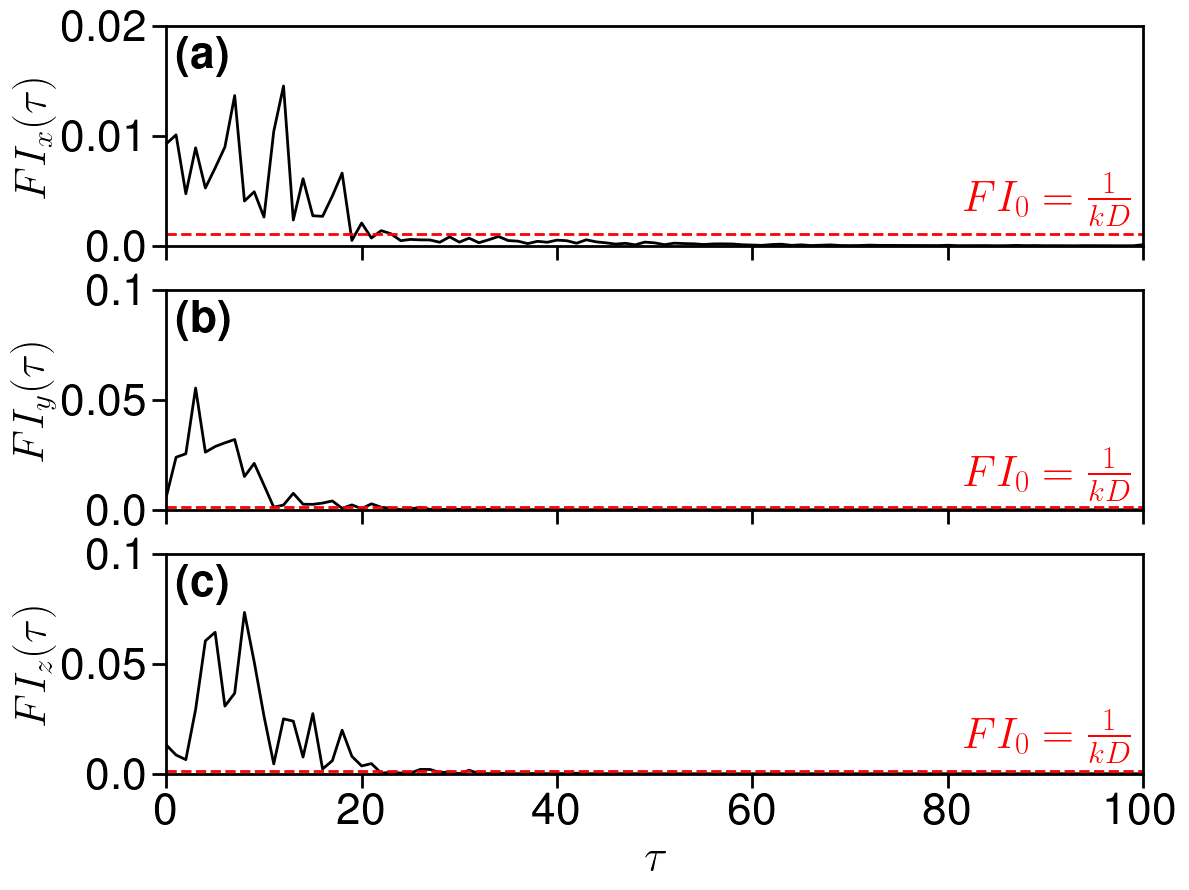

In [200]:
fontsize = 32
ms = 10
lw = 2

dim_labels = ['x', 'y', 'z']

xy_annotate = (0.01,0.95)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, axs = plt.subplots(N,1,figsize=(12,3*N),sharex=True)
axs_lst = [axs] if N==1 else axs

lags = np.arange(k-1)

for i, ax in enumerate(axs_lst):
    ax.plot(lags,FIs[i*k-1:(i-1)*k:-1],'k',lw=lw)
    
    ax.axhline(1/len(FIs), ls='--', c='r', lw=lw)

    ax.set_xlim(0, 100)# k-1)
    ax.set_ylim(0, None)
    
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'{xtick:.0f}' for xtick in xticks], fontsize=fontsize)
    
    ax.text(0.99*ax.get_xlim()[1], 1/len(FIs)+0.05*np.diff(ax.get_ylim()), r'$FI_0=\frac{1}{kD}$', fontsize=fontsize, va='bottom', ha='right',
            color='r')

    ax.set_ylabel(r'$FI_{:}(\tau)$'.format(dim_labels[i]), fontsize=fontsize)
    # ax1.legend(loc='upper right',prop={'size': 24})
    ax.annotate(r'\textbf{('+chr(97+i)+')}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
#             ax.set_xticks(xticks)
    yticks = ax.get_yticks()
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=fontsize)

    if i == N - 1:
        ax.set_xlabel(r'$\tau$', fontsize=fontsize)

    plt.setp(ax.spines.values(), linewidth=2, zorder=100)
    ax.tick_params(length=10,width=2)

    ax.set_zorder(N-i)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2,wspace=0.15)
fig.align_labels(axs)

fname = 'FIs'
plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

In [52]:
s = y_train[-k*xi:len(y_train)].T.flatten()
y_pred_TreeDOX, model, time_elapsed = future_prediction(features, labels, FIs,
                                                        len(y_test), p=None, xi=xi,
                                                        n_estimators=200,
                                                        disp_progress=True,
                                                        desc='',
                                                        max_depth=None,
                                                        random_state=None,
                                                        n_jobs=-1,
                                                        min_samples_split=2,
                                                        min_samples_leaf=1,
                                                        ccp_alpha=0,
                                                        max_features=1.0,
                                                        n_samples=None,
                                                        model=None, s=s,
                                                        model_type='ETR',
                                                        verbose=False,
                                                        model_conversion=None,
                                                        device='mps')

Num features selected: 64 of 957
Training time: 00 hours, 00 minutes, 20.881048 seconds
RAM Used: 2.6G


  0%|          | 0/2183 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 37.947142 seconds


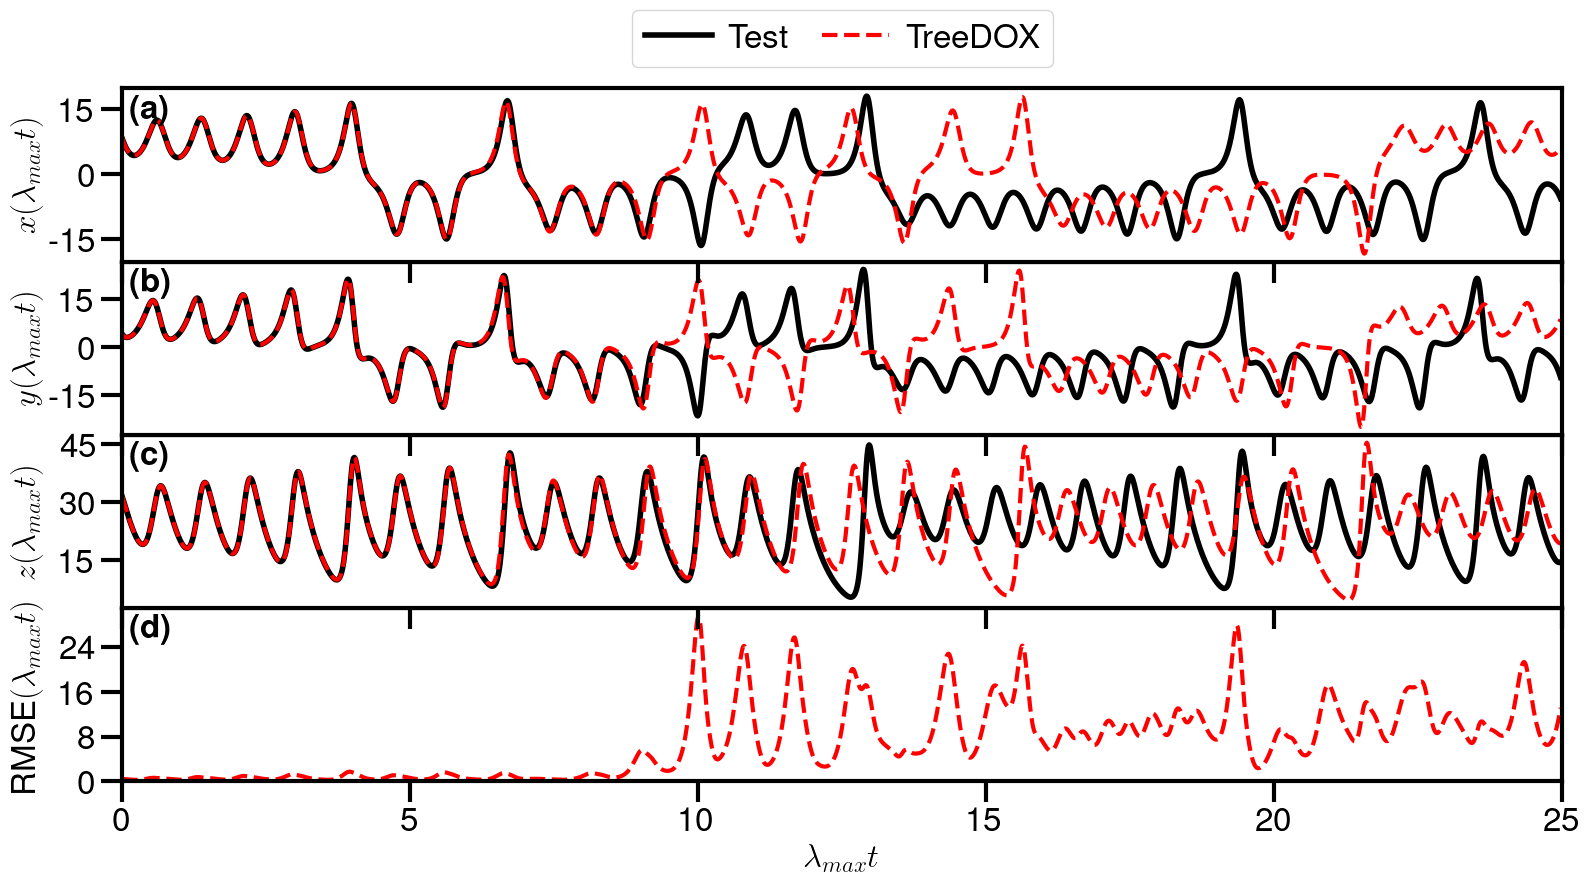

In [53]:
pred_data_lst = [y_pred_TreeDOX]
label_lst = ['TreeDOX']
color_lst = ['r']
lw_lst = [3]
ls_lst = ['--']
ylabels = ['$x$','$y$','$z$','RMSE']

plot_test_results(y_test, pred_data_lst, label_lst, color_lst, lw_lst, ls_lst, 
                  ylabels=ylabels, save_fig=False, fname='', mag_format=False,
                  num_fmt='.0f', LE_max=LE_max, dt=dt)

In [116]:
with gzip.open(data_dir + 'TreeDOX_Results.data', 'wb') as file:
    pkl.dump(y_pred_TreeDOX, file)

# Plots

In [133]:
for var in ['RNN', 'LSTM', 'RC', 'NGRC', 'TreeDOX']:
    with gzip.open(data_dir + f'{var}_Results.data', 'rb') as file:
        globals()[f'y_pred_{var}'] = pkl.load(file)

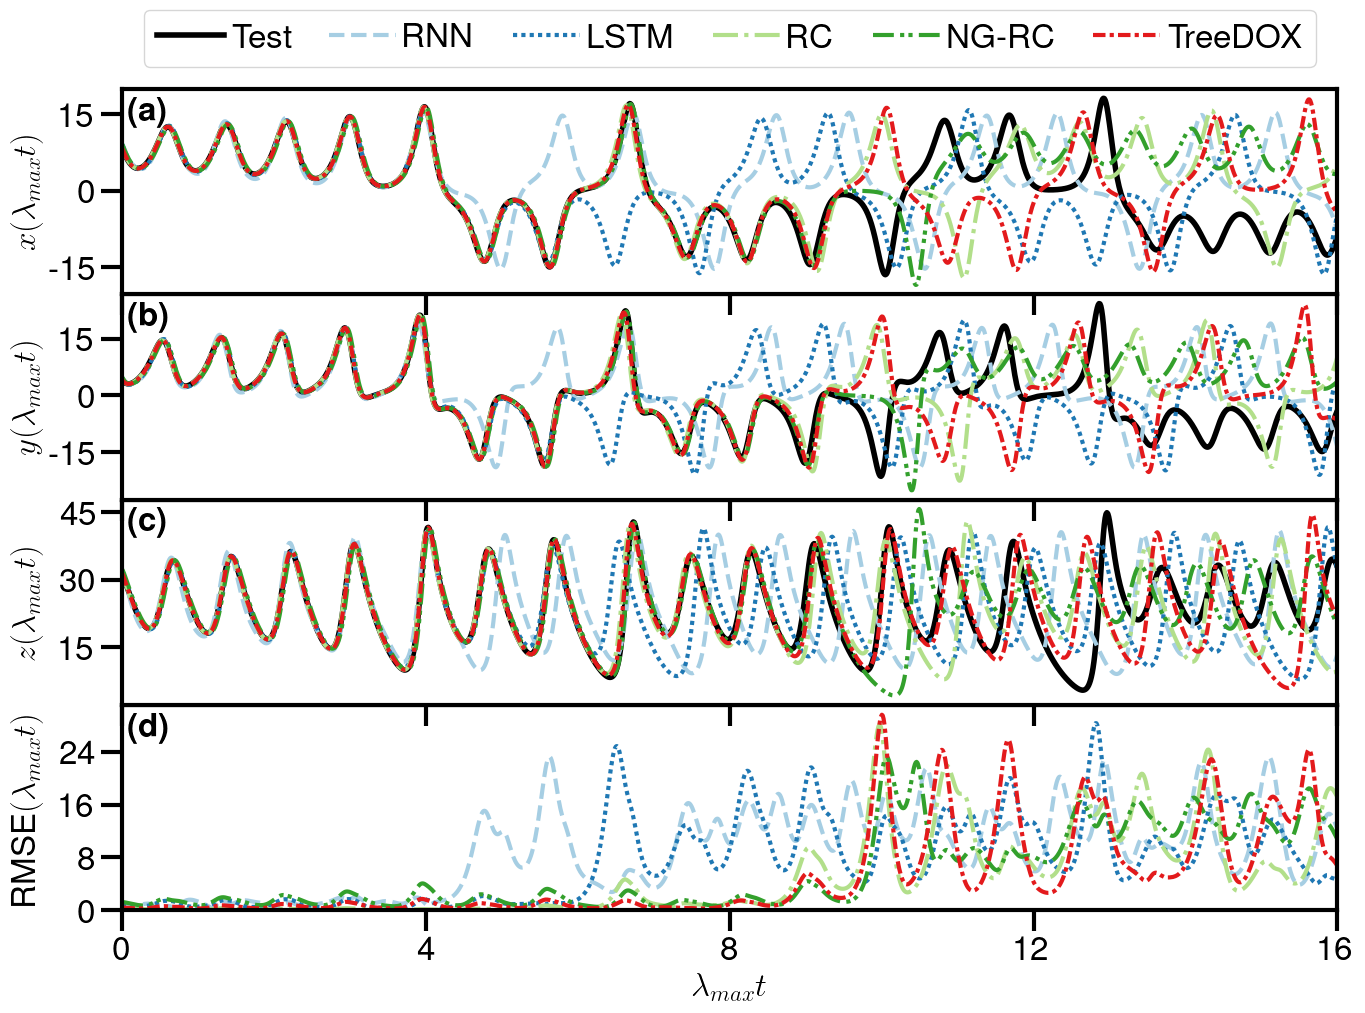

In [141]:
cmap = mpl.cm.Paired
qualitative = True

pred_data_lst = [y_pred_RNN, y_pred_LSTM, y_pred_RC, y_pred_NGRC, y_pred_TreeDOX]
label_lst = ['RNN', 'LSTM', 'RC', 'NG-RC', 'TreeDOX']
color_lst = cmap(np.arange(len(pred_data_lst))) if qualitative else cmap(np.linspace(0,1,len(pred_data_lst)))
color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
color_lst[-1] = cmap(len(pred_data_lst))[:-1]
lw_lst = [3]*len(pred_data_lst)
ls_lst = ['--', (0, (1, 1, 1, 1)), (0, (6, 1.5, 1, 1.5)), (0, (5, 1.5, 1, 1, 1, 1.5)), (0, (3, 1, 1, 1))]
ylabels = ['$x$','$y$','$z$','RMSE']

plot_test_results(y_test, pred_data_lst, label_lst, color_lst, lw_lst, ls_lst, ylabels=ylabels, 
                  save_fig=True, fname='Lorenz - TreeDOX vs RNN, LSTM, RC, NG-RC', mag_format=False, num_fmt='.0f', lw_test=4,
                  columnspacing=1.1, handletextpad=0.25, LE_max=0.8739, x_max=16, dt=dt, aspect_ratio=3./2)